<a href="https://colab.research.google.com/github/MariiaKalinina/BM/blob/main/Basin_worked_ipynb_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from math import *
from scipy.special import lambertw
import matplotlib.pyplot as plt

In [2]:
!pip install GitPython

In [3]:
from git import Repo
!git clone https://github.com/MariiaKalinina/BM.git

Cloning into 'BM'...
remote: Enumerating objects: 1070, done.
remote: Counting objects: 100% (439/439), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 1070 (delta 326), reused 225 (delta 225), pack-reused 631 (from 1)
Receiving objects: 100% (1070/1070), 116.43 MiB | 10.90 MiB/s, done.
Resolving deltas: 100% (587/587), done.
Updating files: 100% (171/171), done.


### Step 0. Data preparation

In [4]:
# import pandas as pd

# df_constast = pd.read_csv('/content/BM/Constants.csv', delimiter=';', header=0)
# df_well = pd.read_csv('/content/BM/Well_parametrs.csv', delimiter=';', header=0)

df_constast = pd.read_csv('/content/BM/Initial data/Constants.csv', delimiter=';', header=0)
df_well = pd.read_csv('/content/BM/Initial data/Well_parametrs_test1.csv', delimiter=';', header=0)


# df_well = pd.read_csv('/content/Well_parametrs_v1.csv', delimiter=';', header=0) ### пример для 3х слойной модели
# df_well = pd.read_csv('/content/BM/Well_parametrs_A13.csv', delimiter=';', header=0) ### Geoterm test - Appendix 13

df_well[['Depth top, m', 'Depth bottom, m']] = df_well[['Depth top, m', 'Depth bottom, m']].apply(lambda x: x / 1000)

In [5]:
df_well

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
0,Test_well,Erosion,Erosion,NaN,0,0.00,0.00,0,NaN,300,0,NaN,NaN,NaN,NaN,NaN,NaN
1,Test_well,Layer 10,Erosion,Shales,0,0.00,0.20,200,NaN,300,0,On,0.0,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstones,45,0.20,0.45,250,NaN,325,40,On,0.0,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shales,55,0.45,1.20,750,NaN,350,50,On,0.0,NaN,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk,80,1.20,2.50,1300,NaN,300,100,On,0.0,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstones,100,2.50,3.40,900,NaN,200,80,On,0.0,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestones,125,3.40,3.60,200,NaN,20,70,On,0.0,Source Rock,Tegelaar(1994)_TI-S(Spain),10.0,100.0
7,Test_well,Layer 4,Deposition,Dolomite,145,3.60,4.00,400,NaN,20,-40,On,0.0,NaN,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstones,160,4.00,4.25,250,NaN,10,-20,On,0.0,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,On,0.0,NaN,NaN,NaN,NaN


In [6]:
df_constast

,Lithology_type,Porosity,"Exp_decay, km-1",Grain density,TC matrix,Radiogenic Heat Production,Ki_framework
0,Shales,0.63,0.51,2720,2.0,1.700000e-06,2.0
1,Sandstones,0.49,0.27,2650,5.5,1.200000e-06,5.5
2,Chalk,0.70,0.71,2710,3.3,4.000000e-07,3.3
3,Limestones,0.40,0.60,2710,3.3,5.000000e-07,3.3
4,Dolomite,0.20,0.60,2870,5.3,4.000000e-07,5.3
5,Anhydrite,0.05,0.20,2960,6.3,1.000000e-07,6.3
6,Quartzite,0.20,0.30,2650,7.7,5.000000e-07,7.7
7,Fundament,0.00,0.00,2800,3.0,2.800000e-06,3.0


In [7]:
# Кол-во слоев по которым будет проходит расчет.
# Не учитывает первый слой - Эрозию и последний - Фундамент
layers_quantity = len(df_well[1:df_well.shape[0]-1]) #amount of layers for calculation
layers_quantity

10

In [8]:
work_layers = df_well[1:df_well.shape[0]-1] ### Слои, по которым идет расчет
work_layers

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
1,Test_well,Layer 10,Erosion,Shales,0,0.00,0.20,200,NaN,300,0,On,0.0,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstones,45,0.20,0.45,250,NaN,325,40,On,0.0,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shales,55,0.45,1.20,750,NaN,350,50,On,0.0,NaN,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk,80,1.20,2.50,1300,NaN,300,100,On,0.0,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstones,100,2.50,3.40,900,NaN,200,80,On,0.0,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestones,125,3.40,3.60,200,NaN,20,70,On,0.0,Source Rock,Tegelaar(1994)_TI-S(Spain),10.0,100.0
7,Test_well,Layer 4,Deposition,Dolomite,145,3.60,4.00,400,NaN,20,-40,On,0.0,NaN,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstones,160,4.00,4.25,250,NaN,10,-20,On,0.0,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,On,0.0,NaN,NaN,NaN,NaN
10,Test_well,Layer 1,Deposition,Quartzite,245,5.00,5.40,400,NaN,0,0,On,0.0,NaN,NaN,NaN,NaN


In [9]:
# filtered_df = df_well[df_well['Event_name'] != 'Erosion']

### Lithology

In [10]:
lithology_numbers = {30000: {'lith':'Sandstones', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                 65030: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 65000: {'lith':'Shales', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                 80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 74000: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                 70000: {'lith':'Limestones', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 70032: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                 99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 90000: {'lith':'Quartzite', 'lith_num':11, 'hatch':'', 'color':'black'},
                 93000: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

In [11]:
pd_lithology = work_layers.copy()
pd_lithology["Lithology"] = ['65000', '30000', '65000', '70032', '30000', '70000', '74000', '30000', '86000', '90000']
pd_lithology["Lithology"] = pd_lithology["Lithology"].astype(int)

In [12]:
pd_lithology

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %",Lithology
1,Test_well,Layer 10,Erosion,Shales,0,0.00,0.20,200,NaN,300,0,On,0.0,NaN,NaN,NaN,NaN,65000
2,Test_well,Layer 9,Deposition,Sandstones,45,0.20,0.45,250,NaN,325,40,On,0.0,NaN,NaN,NaN,NaN,30000
3,Test_well,Layer 8,Deposition,Shales,55,0.45,1.20,750,NaN,350,50,On,0.0,NaN,NaN,NaN,NaN,65000
4,Test_well,Layer 7,Deposition,Chalk,80,1.20,2.50,1300,NaN,300,100,On,0.0,NaN,NaN,NaN,NaN,70032
5,Test_well,Layer 6,Deposition,Sandstones,100,2.50,3.40,900,NaN,200,80,On,0.0,NaN,NaN,NaN,NaN,30000
6,Test_well,Layer 5,Deposition,Limestones,125,3.40,3.60,200,NaN,20,70,On,0.0,Source Rock,Tegelaar(1994)_TI-S(Spain),10.0,100.0,70000
7,Test_well,Layer 4,Deposition,Dolomite,145,3.60,4.00,400,NaN,20,-40,On,0.0,NaN,NaN,NaN,NaN,74000
8,Test_well,Layer 3,Deposition,Sandstones,160,4.00,4.25,250,NaN,10,-20,On,0.0,NaN,NaN,NaN,NaN,30000
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,On,0.0,NaN,NaN,NaN,NaN,86000
10,Test_well,Layer 1,Deposition,Quartzite,245,5.00,5.40,400,NaN,0,0,On,0.0,NaN,NaN,NaN,NaN,90000


In [13]:
df_lith = pd.DataFrame.from_dict(lithology_numbers, orient='index')
df_lith.index.name = 'LITHOLOGY'
df_lith

,lith,lith_num,hatch,color
LITHOLOGY,,,,
30000,Sandstones,1,..,#ffff00
65030,Sandstone/Shale,2,-.,#ffe119
65000,Shales,3,--,#bebebe
80000,Marl,4,,#7cfc00
74000,Dolomite,5,-/,#8080ff
70000,Limestones,6,+,#80ffff
70032,Chalk,7,..,#80ffff
88000,Halite,8,x,#7ddfbe
86000,Anhydrite,9,,#ff80ff


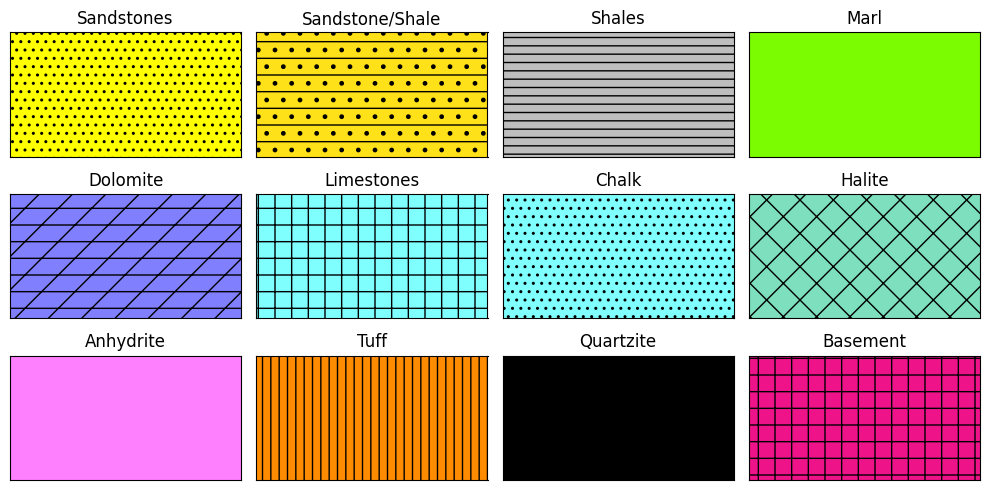

In [14]:
y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=4,nrows=3, sharex=True, sharey=True,
                         figsize=(10,5), subplot_kw={'xticks': [], 'yticks': []})

for ax, key in zip(axes.flat, lithology_numbers.keys()):
    ax.plot(x, y)
    ax.fill_betweenx(y, 0, 1, facecolor=lithology_numbers[key]['color'], hatch=lithology_numbers[key]['hatch'])
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 1)
    ax.set_title(str(lithology_numbers[key]['lith']))

plt.tight_layout()

plt.show()

### Step 1, 2, 3

Step 1. Decompaction (decompacted thickness).

Step 2. Correction for paleobathymetry and eustasy (Decompacted depth with corrction).

Step 3. Removal effect of sediment load (porosity, density).



In [15]:
def decomp_func(y1, y2, y1_d, phi, c):  # возвращает фун-ию одной переменной, для которой затем подбирается параметр y2_d

    y2_d = (np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) - \
            np.exp(-np.log(e) * y1 * c) * phi * np.log(e) + \
            np.exp(-np.log(e) * y2 * c) * phi * np.log(e) - \
            np.log(e) * y1 * c + np.log(e) * y1_d * c + np.log(e) * y2 * c + \
            lambertw(-np.log(e) * phi * np.exp(-np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) +\
                                               np.exp(-np.log(e) * y1 * c) * phi * np.log(e) - \
                                               np.exp(-np.log(e) * y2 * c) * phi * np.log(e) + \
                                               np.log(e) * y1 * c - \
                                               np.log(e) * y1_d * c - np.log(e) * y2 * c))) / c / np.log(e)
    return y2_d.real

In [16]:
#считает скорректированную декомпактированную глубину
def corrected(depth, RoMantle, RoWater, sea_level, sea_level_today):
  return depth - sea_level_today * (RoWater / (RoMantle - RoWater)) + (sea_level - sea_level_today)

In [17]:
### the averaeg porosity of a stratigraphic unit at any depth [A.58.6]
def porosity_func(surface_porosity, exp_decay, y1, y2, thicknesses):
  return surface_porosity/exp_decay*((np.exp(-exp_decay*y1) - np.exp(-exp_decay*y2))/thicknesses)

In [18]:
def bulk_density(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [19]:
def bulk_density_column(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [20]:
def tectonic_subsidence (RoMantle, RoWater, RoColumn, depth):
  return depth*((RoMantle-RoColumn)/(RoMantle-RoWater))

In [21]:

# decompaction_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.3

# age = list(df_well['Age (Ma)'][1:])

# for i, a in enumerate(age, start=0):
#     print('Age', a)

#     work_layers_copy = work_layers.copy()
#     rows_to_delete = []
#     thinkness_list = []

#     for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

#       lithology = work_layers_copy.at[row.Index, 'Lithology_type']
#       layers_name = work_layers_copy.at[row.Index, 'Event_name']

#       if row_index == i: #<--- если первый слов, то y1 decompaced = 0
#         y1_d = 0

#       else:
#         y1_d = y2_d

#       phi0 = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Porosity'].iloc[0]
#       c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
#       y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
#       y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

#       y2_d = decomp_func(y1, y2, y1_d, phi0, c)

#       thicknesses = np.round(y2_d - y1_d, 3) #A58.3
#       thinkness_list.append(thicknesses)

#       print(row_index, lithology, layers_name, thicknesses)
#     print(sum(thinkness_list), end='\n\n')

#     ### Save result in table
#     resized_list = np.zeros(10)
#     resized_list[:len(thinkness_list)] = thinkness_list

#     new_col_values = resized_list[::-1]
#     new_col_name = f'{a} Ma'
#     decompaction_df[new_col_name] = new_col_values

In [22]:
initial_depth_values = []

decompaction_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.3
decompaction_corrected_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.4
porosity_df = pd.DataFrame() ### <-- Porosities as a function of time for 10 lithological units undergoing progressive compaction during burial.
                            ### Table A58.4
density_df = pd.DataFrame()
density_column_df = pd.DataFrame()

age_list = list(df_well['Age (Ma)'][1:])

for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    thinkness_list = []
    thinkness_corrected_list = []
    porosity_average_list = []
    porosity_test = []
    density_list = []
    density_column = []
    density_column_total = []


    RoWater, RoMantle = 1000, 3300
    sea_level = df_well.loc[df_well['Age (Ma)'] == int(age), 'Paleobathymetry, Ma'].iloc[0]/1000
    sea_level_today = df_well.loc[df_well['Age (Ma)'] == int(age), 'Sea level, m'].iloc[0]/1000

    print('Age', age)

### расчет corrected_decompaction for Fundament (not in work_layer)
    if int(age) == age_list[-1]:
          depth = 0
          y2_d_corrected = abs(np.round(corrected(depth, RoMantle, RoWater, sea_level, sea_level_today), 3))
          thinkness_corrected_list.append(y2_d_corrected)

### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      phi0 = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Porosity'].iloc[0]
      c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
      RoGrain = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Grain density'].iloc[0]
      y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

      if int(age) == 0:
        initial_depth_values.append(y1)


      if row_index == i: #<--- если первый слов, то y1 decompaced = 0
        y1_d = 0
        if age == 0:
          pass
        else:
          y1_d_corrected = corrected(y1_d, RoMantle, RoWater, sea_level, sea_level_today)
          thinkness_corrected_list.append(y1_d_corrected)

      else:
        y1_d = y2_d
        y1_d_corrected = y2_d_corrected
### decompaction depth
      y2_d = decomp_func(y1, y2, y1_d, phi0, c)
      thicknesses = y2_d - y1_d #A58.3
      thinkness_list.append(np.round(thicknesses, 3))
### corrected decompaction depth
      y2_d_corrected = corrected(y2_d, RoMantle, RoWater, sea_level, sea_level_today)
      thinkness_corrected_list.append(y2_d_corrected)
### porosity
      porosity = np.round(porosity_func(phi0, c, y1_d, y2_d, thicknesses), 3)
      porosity_average_list.append(np.round(porosity, 3))

### Density
      density = bulk_density(porosity, RoGrain, RoWater)
      density_list.append(int(np.round(density, 2)))

      print(row_index, lithology, layers_name, phi0, c, density)

### Density of entire sediment column [A58.5]
      a = (porosity*RoWater + (1-porosity)*RoGrain)*thicknesses
      density_column.append(a)

    if int(age) == age_list[-1]:
      pass
      density_col = 0
      density_column_total.append(density_col)
    else:
      density_col = sum(density_column)/sum(thinkness_list)
      density_column_total.append(np.round(density_col, 3))
      print(sum(thinkness_list), density_col, end='\n\n')

# for por, RoGrian in zip(porosity_average_list, )

 ### Save results in table
    new_col_name = f'{age}'

    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(thinkness_list):] = thinkness_list


    # resized_list = np.zeros(work_layers_copy.shape[0])
    # resized_list[:len(thinkness_list)] = thinkness_list

    new_col_values = resized_list_new
    decompaction_df[new_col_name] = new_col_values

    ### Save result for corrected decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(thinkness_corrected_list):] = thinkness_corrected_list

    new_col_values_new = resized_list_new
    decompaction_corrected_df[new_col_name] = new_col_values_new

    ### Save result for average porosity in table
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(porosity_average_list):] = porosity_average_list
    new_col_values = resized_list
    porosity_df[new_col_name] = new_col_values

### Save result for the bulk density in table
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(density_list):] = density_list
    new_col_values = resized_list
    density_df[new_col_name] = new_col_values

### Save result for the bulk density of column
    density_column_df[new_col_name] = density_column_total

Age 0
0 Shales Layer 10 0.63 0.51 1689.72
1 Sandstones Layer 9 0.49 0.27 1909.1499999999999
2 Shales Layer 8 0.63 0.51 2004.4800000000002
3 Chalk Layer 7 0.7 0.71 2376.5499999999997
4 Sandstones Layer 6 0.49 0.27 2285.35
5 Limestones Layer 5 0.4 0.6 2626.21
6 Dolomite Layer 4 0.2 0.6 2830.73
7 Sandstones Layer 3 0.49 0.27 2384.35
8 Anhydrite Layer 2 0.05 0.2 2920.7999999999997
9 Quartzite Layer 1 0.2 0.3 2580.7
5.4 2396.5598148148147

Age 45
1 Sandstones Layer 9 0.49 0.27 1869.55
2 Shales Layer 8 0.63 0.51 1940.84
3 Chalk Layer 7 0.7 0.71 2345.77
4 Sandstones Layer 6 0.49 0.27 2273.8
5 Limestones Layer 5 0.4 0.6 2621.08
6 Dolomite Layer 4 0.2 0.6 2828.86
7 Sandstones Layer 3 0.49 0.27 2377.75
8 Anhydrite Layer 2 0.05 0.2 2920.7999999999997
9 Quartzite Layer 1 0.2 0.3 2579.0499999999997
5.3020000000000005 2396.44111964442

Age 55
2 Shales Layer 8 0.63 0.51 1847.96
3 Chalk Layer 7 0.7 0.71 2303.02
4 Sandstones Layer 6 0.49 0.27 2260.6000000000004
5 Limestones Layer 5 0.4 0.6 2614.24
6 Do

In [23]:
# density_column_df

#### Function to save to csv

In [24]:
# File save
def save_to_csv(pd_name, work_layers, output_filename):
    work_layers.reset_index(drop=True, inplace=True)
    pd_name['Event_name'] = work_layers['Event_name']
    pd_name['Lithology_type'] = work_layers['Lithology_type']
    pd_name = pd_name[pd_name.columns[::-1]]

    pd_name.to_csv(output_filename, index=True)

In [25]:
save_to_csv(porosity_df, work_layers, "Porosity-2")

In [26]:
decompaction_df.loc['Stratigraphic thickness (km)', :] = decompaction_df.sum(axis=0) # <-- ввод общией мощности

### добавление колонок Lithology_typeб	Event_name
work_layers.reset_index(drop=True, inplace=True)
decompaction_df['Event_name'] = work_layers['Event_name']
decompaction_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_df = decompaction_df[decompaction_df.columns[::-1]]

decompaction_df.to_csv('/content/Decompaction.csv', index=True)

In [27]:
### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
decompaction_corrected_df['Event_name'] = work_layers['Event_name']
decompaction_corrected_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_corrected_df = decompaction_corrected_df[decompaction_corrected_df.columns[::-1]]

decompaction_corrected_df.to_csv('/content/Decompaction_corrected.csv', index=True)

In [28]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
porosity_df['Event_name'] = work_layers['Event_name']
porosity_df['Lithology_type'] = work_layers['Lithology_type']
porosity_df = porosity_df[porosity_df.columns[::-1]]

porosity_df.to_csv('/content/Porosity.csv', index=True)

In [29]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
density_df['Event_name'] = work_layers['Event_name']
density_df['Lithology_type'] = work_layers['Lithology_type']
density_df = density_df[density_df.columns[::-1]]

density_df.to_csv('/content/Density.csv', index=True)

In [30]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
density_column_df['Event_name'] = work_layers['Event_name']
density_column_df['Lithology_type'] = work_layers['Lithology_type']
density_column_df = density_column_df[density_column_df.columns[::-1]]

density_column_df.to_csv('/content/Density_column.csv', index=True)

#### Plot: "Porosity - Depth" (Comparison with Petromod)

In [31]:
# Petromod

data_ref = pd.read_excel('/content/BM/Charts_Petromod.xlsx', sheet_name='Petromod porosity', skiprows=0, header=0, engine='openpyxl')
data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)

depth_dc, porosity_plot = [],[]

# Create a sample DataFrame with shape 10x2
depth_dc = decompaction_corrected_df['0'].tolist()
porosity_plot = data_ref[0].tolist()

data = {
    'porosity': porosity_plot,
    'depth_dc': depth_dc
}
df = pd.DataFrame(data)

# # Repeat each column in order like 1 cell, 1 cell, 2 cell, 2 cell, 3 cell, 3 cell
# new_data = {key: [val for val in df[key] for _ in range(2)] for key in df.columns}



# Rewrite the dictionary comprehension as a list comprehension
new_data_list = [(key, [val for val in df[key] for _ in range(2)]) for key in df.columns]
new_data_list[0][1].append(0)
new_data_list[1][1].insert(0, 0)

# Display the new_data_list
print(new_data_list[0][1])

# Convert the list of tuples to a dictionary
data_dict = {key: value for key, value in new_data_list}

# Create a DataFrame from the dictionary
new_df_ref = pd.DataFrame(data_dict)

[0.5992999999999999, 0.5992999999999999, 0.4499, 0.4499, 0.41229999999999994, 0.41229999999999994, 0.2012, 0.2012, 0.225, 0.225, 0.0489, 0.0489, 0.0215, 0.0215, 0.1645, 0.1645, 0.0209, 0.0209, 0.0444, 0.0444, 0]


<ipython-input-31-a354dcea669c>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)


In [32]:
# Calculated data

depth_dc, porosity_plot = [],[]

# Create a sample DataFrame with shape 10x2
depth_dc = decompaction_corrected_df['0'].tolist()
porosity_plot = porosity_df['0'].tolist()

data = {
    'porosity': porosity_plot,
    'depth_dc': depth_dc
}
df = pd.DataFrame(data)

# # Repeat each column in order like 1 cell, 1 cell, 2 cell, 2 cell, 3 cell, 3 cell
# new_data = {key: [val for val in df[key] for _ in range(2)] for key in df.columns}



# Rewrite the dictionary comprehension as a list comprehension
new_data_list = [(key, [val for val in df[key] for _ in range(2)]) for key in df.columns]
new_data_list[0][1].append(0)
new_data_list[1][1].insert(0, 0)

# Display the new_data_list
print(new_data_list[0][1])

# Convert the list of tuples to a dictionary
data_dict = {key: value for key, value in new_data_list}

# Create a DataFrame from the dictionary
new_df = pd.DataFrame(data_dict)

[0.599, 0.599, 0.449, 0.449, 0.416, 0.416, 0.195, 0.195, 0.221, 0.221, 0.049, 0.049, 0.021, 0.021, 0.161, 0.161, 0.02, 0.02, 0.042, 0.042, 0]


In [33]:
new_df_ref['porosity'], new_df['depth_dc']

(0     0.5993
 1     0.5993
 2     0.4499
 3     0.4499
 4     0.4123
 5     0.4123
 6     0.2012
 7     0.2012
 8     0.2250
 9     0.2250
 10    0.0489
 11    0.0489
 12    0.0215
 13    0.0215
 14    0.1645
 15    0.1645
 16    0.0209
 17    0.0209
 18    0.0444
 19    0.0444
 20    0.0000
 Name: porosity, dtype: float64,
 0     0.00
 1     0.50
 2     0.50
 3     0.75
 4     0.75
 5     1.50
 6     1.50
 7     2.80
 8     2.80
 9     3.70
 10    3.70
 11    3.90
 12    3.90
 13    4.30
 14    4.30
 15    4.55
 16    4.55
 17    5.30
 18    5.30
 19    5.70
 20    5.70
 Name: depth_dc, dtype: float64)

In [34]:
def makeplot_porosity(property, top_depth, bottom_depth):
    # fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    # ax = fig.subplots(1, 2,  sharex=False)

    fig, ax = plt.subplots(figsize=(14,7))

    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

### Plot 1
    # Geotherma
    ax1.plot(new_df_ref['porosity'], new_df['depth_dc'], label='Petromod', color='red')
    ax1.plot(new_df['porosity'], new_df['depth_dc'], label='BM', color='black')
    ax1.set_xlabel(f'Porosity', labelpad=20)
    ax1.set_ylabel(f'Depth (km)')
    ax1.legend(loc='upper left')
    ax1.set_xlim(0, 0.6)

### Plot 2
    # Lithology track
    # ax2.plot(T_with_rad_heat["Lithology"], T_with_rad_heat['depth 0'], color = "black", linewidth = 0.5)
    ax2.set_xlabel("Lithology")
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(pd_lithology["Lithology"], decompaction_corrected_df['0']):
        key = int(lit)
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']

        depth_values = [depth_start, depth]
        depth_start = depth

        ax2.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch)

    ax2.set_xticks([0, 1])

### Plot3
    ax3.set_xlabel("Lithology")
    ax3.set_xlim(0, 1)
    ax3.xaxis.label.set_color("black")
    ax3.tick_params(axis='x', colors="black")
    ax3.spines["top"].set_edgecolor("black")
    ax3.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(property["Lithology_type"], decompaction_corrected_df['0']):
        key = lit
        depth_values = [depth_start, depth]
        depth_start = depth

        label_position = (0.5, sum(depth_values) / 2)  # Assuming x position is at 0.5
        ax3.text(label_position[0], label_position[1], key, ha='center', va='center')
        ax3.plot([0, 1], [depth, depth], color='black', linewidth=1)  # Assuming black color and linewidth of 1


    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    return plt.savefig("porosity-depth.png")

In [35]:
# Select the columns you want to save
data_to_save = new_df[['porosity', 'depth_dc']]
data_to_save.to_csv('porosity_depth_data.csv', index=False)  # index=False prevents saving row numbers

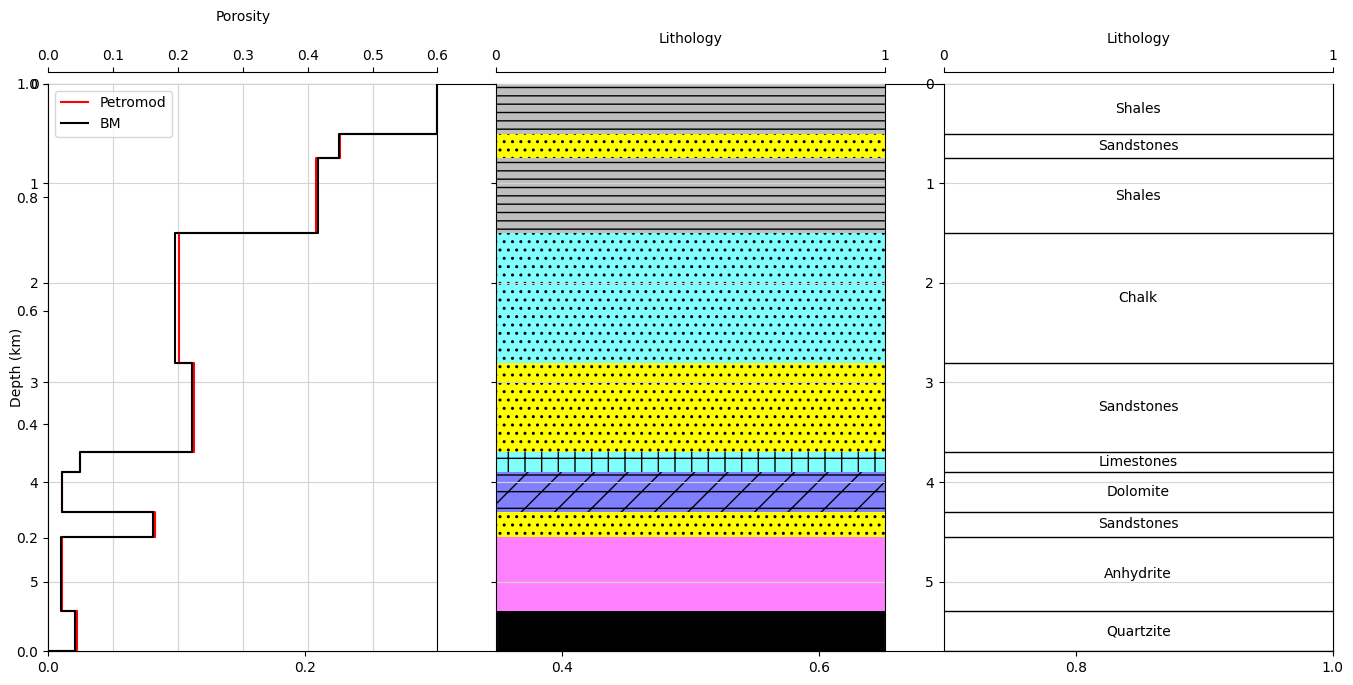

In [36]:
makeplot_porosity(porosity_df, 0, max(decompaction_corrected_df['0']))

### Tectonic driving subsidence [A58.7]

In [37]:
### Tectonic driving subsidence [A58.7]
RoWater, RoMantle = 1000, 3300
# y = tectonic_subsidence(RoMantle, RoWater, density_column, thicknesses)

# decompaction_corrected_df.iloc[2:]
thicknesses = decompaction_corrected_df.iloc[:, 2:decompaction_corrected_df.shape[1]]
density_column_test = density_column_df.iloc[:, 2:density_column_df.shape[1]]

# density_column_test.shape, thicknesses.shape


# Initialize an empty list to store the output values
output_values = []
col_name = list(df_well['Age (Ma)'][1:])[::-1]
print(len(col_name))


for columns2, column_name in zip(thicknesses.columns, density_column_test.columns):
  y = tectonic_subsidence(RoMantle, RoWater,
                          density_column_test[column_name].values,
                          thicknesses[columns2].values)
  output_values.append(y)

output_df = pd.DataFrame(output_values).T[::-1].rename(columns=dict(enumerate(col_name)))
output_df

11


,260,245,210,160,145,125,100,80,55,45,0
9,0.048783,0.196275,0.324557,0.563523,0.683447,0.751489,1.346034,2.002260,2.177413,2.188169,2.23896
8,0.000000,0.000000,0.206856,0.411824,0.542790,0.605545,1.182022,1.836816,2.017534,2.030822,2.08184
7,0.000000,0.000000,0.005231,0.147981,0.294551,0.345952,0.883055,1.528742,1.718372,1.736065,1.78724
6,0.000000,0.000000,0.000000,0.013293,0.179004,0.230643,0.767320,1.422240,1.617568,1.637339,1.68904
5,0.000000,0.000000,0.000000,0.000000,0.025108,0.074658,0.600330,1.256647,1.457685,1.479994,1.53192
4,0.000000,0.000000,0.000000,0.000000,0.000000,-0.027347,0.508703,1.172505,1.377392,1.401171,1.45336
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033612,0.779754,1.012036,1.044694,1.09984
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064106,0.464643,0.522174,0.58920
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110894,0.207851,0.29460
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105131,0.19640


#### Plot: "Tectonic subsidence Y after decompaction and backstripping" (Comparison with Petromod) [Fig. A58.2]


<ipython-input-38-42c6dd4a6d24>:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


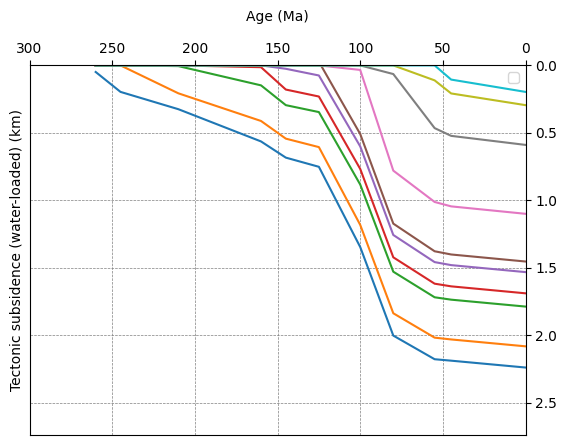

In [38]:
# work_layers = decompaction_corrected_df.drop(['Lithology_type', 'Event_name'], axis=1, inplace=False)
# age_values = [int(age.split(' Ma')[0]) for age in work_layers.columns.tolist()]
age_values  = [int(age) for age in df_well['Age (Ma)'][1:]][::-1]
# age_values = list(df_well['Age (Ma)'][1:])[::-1]

# work_layers_copy = work_layers.copy()

# # Plot the lines for each row in work_layers_copy
for row_index, row in output_df.iterrows():
    plt.plot(age_values, row.values)

# # Calculate sea level and sea level today
# sea_level = df_well[1:df_well.shape[0]]['Paleobathymetry, Ma'] / 1000
# sea_level_today = df_well[1:df_well.shape[0]]['Sea level, m'] / 1000

# # Plot sea level and present-day sea level
# plt.plot(age_values, (abs(sea_level - sea_level_today))[::-1], 'k--', label='Sea level')
# plt.plot(age_values, np.zeros(work_layers_copy.shape[1]), 'k--', label='present-day sea level')

# # Fill the space between the two sea level plots with blue color
# plt.fill_between(age_values, np.zeros(work_layers_copy.shape[1]),
#  (abs(sea_level - sea_level_today))[::-1], color='blue', alpha=0.2, label='Sea level' )

# Additional plotting settings
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Age (Ma)', labelpad=20)
plt.ylabel(f'Tectonic subsidence (water-loaded) (km)')
plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

In [39]:
# Data reference Petromod
data_ref = pd.read_excel('/content/BM/Charts_Petromod.xlsx', sheet_name='Petromod Depth', skiprows=0, header=0, engine='openpyxl')
data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)

<ipython-input-39-c89595cffcaa>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_ref = data_ref.applymap(lambda x: x.split('\t') if isinstance(x, str) else x)


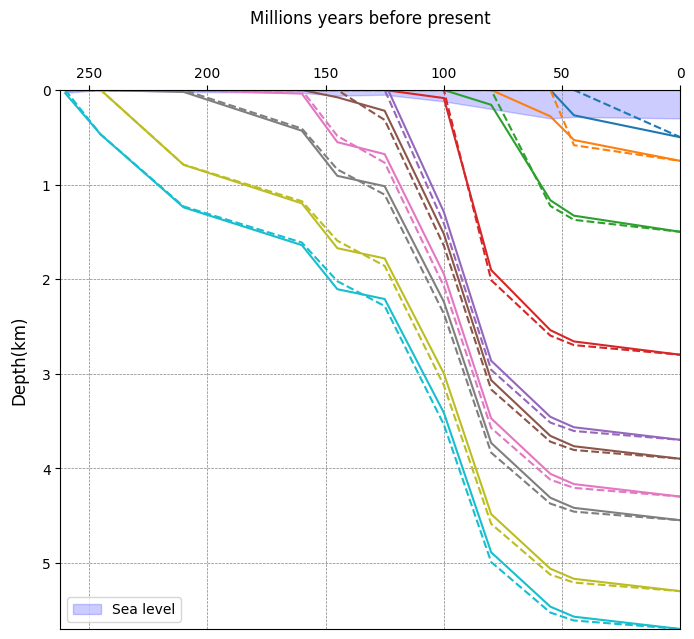

<Figure size 640x480 with 0 Axes>

In [40]:
plt.figure(figsize=(8, 7))

    # Our data
work_layers = decompaction_corrected_df.drop(['Lithology_type', 'Event_name'], axis=1, inplace=False)
age_values = [int(age.split(' Ma')[0]) for age in work_layers.columns.tolist()]
work_layers_copy = work_layers.copy()

# Plot the lines for each row in work_layers_copy
for row_index, row in work_layers_copy.iterrows():
  plt.plot(age_values, row.values, linestyle='solid')

    # Petromode
work_layers = data_ref.drop(['Unnamed: 0', 'Lithology_type', 'Event_name'], axis=1, inplace=False)
work_layers_copy = work_layers.copy()

for row_index, row in work_layers_copy.iterrows():
  plt.plot(age_values, row.values, linestyle='dashed')

# Calculate sea level and sea level today
sea_level = df_well[1:df_well.shape[0]]['Paleobathymetry, Ma'] / 1000
sea_level_today = df_well[1:df_well.shape[0]]['Sea level, m'] / 1000

# # Plot sea level and present-day sea level
# plt.plot(age_values, (abs(sea_level - sea_level_today))[::-1], 'k--', label='Sea level')
# plt.plot(age_values, np.zeros(work_layers_copy.shape[1]), 'k--', label='present-day sea level')

# Fill the space between the two sea level plots with blue color
plt.fill_between(age_values, np.zeros(work_layers_copy.shape[1]),
 (abs(sea_level - sea_level_today))[::-1], color='blue', alpha=0.2, label='Sea level' )

# Additional plotting settings
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(work_layers_copy), -1])
plt.axis([262, 0, np.max(work_layers_copy), 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Millions years before present', labelpad=10, fontsize=12)
plt.ylabel(f'Depth(km)', labelpad=10, fontsize=12)
plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend(loc='lower left')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()
plt.savefig("age-depth.png")

### Step 4: Thermal conductivity of the basin-fill

In [41]:
def bulk_thermal_conductivity(tc_matrix, tc_includion, porosity):
  return tc_matrix*(1-porosity) + tc_includion*porosity

In [42]:
def geotherm_constant_heat(surface_T, basal_HF, depth, tc_bulk):
  return surface_T + (-basal_HF*depth * tc_bulk**-1)

In [43]:
work_layers = df_well[1:df_well.shape[0]-1] ### Слои, по которым идет расчет
work_layers

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
1,Test_well,Layer 10,Erosion,Shales,0,0.00,0.20,200,NaN,300,0,On,0.0,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstones,45,0.20,0.45,250,NaN,325,40,On,0.0,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shales,55,0.45,1.20,750,NaN,350,50,On,0.0,NaN,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk,80,1.20,2.50,1300,NaN,300,100,On,0.0,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstones,100,2.50,3.40,900,NaN,200,80,On,0.0,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestones,125,3.40,3.60,200,NaN,20,70,On,0.0,Source Rock,Tegelaar(1994)_TI-S(Spain),10.0,100.0
7,Test_well,Layer 4,Deposition,Dolomite,145,3.60,4.00,400,NaN,20,-40,On,0.0,NaN,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstones,160,4.00,4.25,250,NaN,10,-20,On,0.0,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,On,0.0,NaN,NaN,NaN,NaN
10,Test_well,Layer 1,Deposition,Quartzite,245,5.00,5.40,400,NaN,0,0,On,0.0,NaN,NaN,NaN,NaN


In [44]:
tc_bulk_df = pd.DataFrame()

age_list = list(df_well['Age (Ma)'][1:])
print(age_list)

for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    tc_bulk_list = []

    # thinkness_list = []
    # thinkness_corrected_list = []
    # porosity_average_list = []
    # porosity_test = []
    # density_list = []
    # density_column = []
    # density_column_total = []

    RoWater, RoMantle = 1000, 3300
    tc_water = 0.60
    sea_level = df_well.loc[df_well['Age (Ma)'] == int(age), 'Paleobathymetry, Ma'].iloc[0]/1000
    sea_level_today = df_well.loc[df_well['Age (Ma)'] == int(age), 'Sea level, m'].iloc[0]/1000

    print('Age', age)

    ### расчет corrected_decompaction for Fundament (not in work_layer)
    if int(age) == age_list[-1]:
          tc_bulk = 0
          tc_bulk_list.append(tc_bulk)


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      phi0 = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Porosity'].iloc[0]
      tc_matrix = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'TC matrix'].iloc[0]

      # c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
      # RoGrain = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Grain density'].iloc[0]
      # y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      # y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

### Bulk thermal conductivity
      tc_bulk = bulk_thermal_conductivity(tc_matrix, tc_water, phi0)
      tc_bulk_list.append(tc_bulk)
      print(row_index, lithology, layers_name, phi0, np.round(bulk_thermal_conductivity(tc_matrix, tc_water, phi0), 2))


### Save results in table
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(tc_bulk_list):] = tc_bulk_list
    new_col_values = resized_list_new
    tc_bulk_df[new_col_name] = new_col_values

[0, 45, 55, 80, 100, 125, 145, 160, 210, 245, 260]
Age 0
0 Shales Layer 10 0.63 1.12
1 Sandstones Layer 9 0.49 3.1
2 Shales Layer 8 0.63 1.12
3 Chalk Layer 7 0.7 1.41
4 Sandstones Layer 6 0.49 3.1
5 Limestones Layer 5 0.4 2.22
6 Dolomite Layer 4 0.2 4.36
7 Sandstones Layer 3 0.49 3.1
8 Anhydrite Layer 2 0.05 6.02
9 Quartzite Layer 1 0.2 6.28
Age 45
1 Sandstones Layer 9 0.49 3.1
2 Shales Layer 8 0.63 1.12
3 Chalk Layer 7 0.7 1.41
4 Sandstones Layer 6 0.49 3.1
5 Limestones Layer 5 0.4 2.22
6 Dolomite Layer 4 0.2 4.36
7 Sandstones Layer 3 0.49 3.1
8 Anhydrite Layer 2 0.05 6.02
9 Quartzite Layer 1 0.2 6.28
Age 55
2 Shales Layer 8 0.63 1.12
3 Chalk Layer 7 0.7 1.41
4 Sandstones Layer 6 0.49 3.1
5 Limestones Layer 5 0.4 2.22
6 Dolomite Layer 4 0.2 4.36
7 Sandstones Layer 3 0.49 3.1
8 Anhydrite Layer 2 0.05 6.02
9 Quartzite Layer 1 0.2 6.28
Age 80
3 Chalk Layer 7 0.7 1.41
4 Sandstones Layer 6 0.49 3.1
5 Limestones Layer 5 0.4 2.22
6 Dolomite Layer 4 0.2 4.36
7 Sandstones Layer 3 0.49 3.1
8 An

In [45]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
tc_bulk_df['Event_name'] = work_layers['Event_name']
tc_bulk_df['Lithology_type'] = work_layers['Lithology_type']
tc_bulk_df= tc_bulk_df[tc_bulk_df.columns[::-1]]

tc_bulk_df.to_csv('/content/TC_bulk.csv', index=True)

In [46]:
tc_bulk_df

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.118
1,Sandstones,Layer 9,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.099,3.099
2,Shales,Layer 8,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,1.118,1.118,1.118
3,Chalk,Layer 7,0.0,0.00,0.000,0.000,0.000,0.000,0.000,1.410,1.410,1.410,1.410
4,Sandstones,Layer 6,0.0,0.00,0.000,0.000,0.000,0.000,3.099,3.099,3.099,3.099,3.099
5,Limestones,Layer 5,0.0,0.00,0.000,0.000,0.000,2.220,2.220,2.220,2.220,2.220,2.220
6,Dolomite,Layer 4,0.0,0.00,0.000,0.000,4.360,4.360,4.360,4.360,4.360,4.360,4.360
7,Sandstones,Layer 3,0.0,0.00,0.000,3.099,3.099,3.099,3.099,3.099,3.099,3.099,3.099
8,Anhydrite,Layer 2,0.0,0.00,6.015,6.015,6.015,6.015,6.015,6.015,6.015,6.015,6.015
9,Quartzite,Layer 1,0.0,6.28,6.280,6.280,6.280,6.280,6.280,6.280,6.280,6.280,6.280


## Step 5. Calculation of the geotherm with variable thermal conductivity (a constant heat flow from the mantle)

## Step 6. The radiogenic heat contribution: Eqn. [A58.10]

In [47]:
def linear_geotherm(G, y):
  return G*y

In [48]:
def linear_geotherm_2(T0, qm, A, yc, depth, K):
  return T0 + ((-Qm + A*yc)/K)*depth - (A/(2*K)*depth**2)

### Ap.13: Effects of variable radiogenic heating and thermal conductivity on the geotherm in the basin-fill - CHECK

In [49]:
T_with_rad_heat = pd.DataFrame()
T_without_rad_heat = pd.DataFrame()
T_linear_geotherm =  pd.DataFrame()

age_list = list(df_well['Age (Ma)'][1:2])
print(age_list)


for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    T_list = []
    T_list_constant = []
    T_linear_geotherm_values = []


    Qm = 0
    T0 = 15
    G = 20

    print('Age', age)


    sum_variables_1, sum_variables_2 = [], []
    sum_variables_3, sum_variables_4 = [], []
    sum_variables_5 = []
    layers_sum = []
    layers_sum_1 = []



### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      A = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Layer radiogenic\nheat production'].iloc[0] * 10**-6
      K = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Layer bulk\nconductivity'].iloc[0]

      thickness_layer = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Thickness, m'].iloc[0]

      crust_depth = 5

      depth = work_layers.loc[work_layers['Lithology_type'] == str(lithology), 'Depth bottom, m'].iloc[0]

### With radio heat
      Qm = 30*10**-3 # Qm = 30 - ни где не указано в книги, сама подобрала
      if K == 0:
        sum_variables_1.append(0)
        sum_variables_2.append(0)
      else:
        layers_sum.append(thickness_layer)
        crust_depth = sum(layers_sum)

        sum_variables_1.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_2.append((A/(2*K))*(thickness_layer)**2)


      T = T0 + (sum(sum_variables_1) - sum(sum_variables_2))
      T_list.append(T)

      print(row_index, lithology, crust_depth, thickness_layer, K, A, T_list)



### without radio heat

      Qm = 25*10**-3
      A = 2.5 * 10**-6
      K= 3

###!!!!!!!!!!!!!!!!!!!!!! crust depth = 5km and change for each layer
      layers_sum_1.append(thickness_layer)
      crust_depth = sum(layers_sum_1)
###!!!!!!!!!!!!!!!!!!!!!!
      if K == 0:
        sum_variables_3.append(0)
      else:
        sum_variables_3.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_4.append((A/(2*K))*(thickness_layer)**2)

      T_no_heat = T0 + (sum(sum_variables_3) - sum(sum_variables_4))
      T_list_constant.append(T_no_heat)


# ### Linear teady-stage geotherm Appendix 12
      Qm = -60 * 10**-3
      A = 0
      yc = 30 *1000
      K= 3
      depth *=1000

      # T_linear_geotherm_values.append(T0 + ((-Qm + A*yc)/K)*depth - (A/(2*K)*depth**2))

      T_linear_geotherm_values.append(linear_geotherm_2(T0, qm, A, yc, depth, K))

      print(T_list_constant)
      print(T_linear_geotherm_values)

### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_with_rad_heat[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_list_constant
    new_col_values = resized_list_new
    T_without_rad_heat[new_col_name] = new_col_values


### Linear teady-stage geotherm Appendix 12
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_linear_geotherm_values
    new_col_values = resized_list_new
    T_linear_geotherm[new_col_name] = new_col_values

[0]
Age 0


KeyError: 'Layer radiogenic\nheat production'

In [50]:
T0 = 15
Linear = T_linear_geotherm["0.0"].tolist()
Linear.insert(0, T0)


A_line = T_without_rad_heat["0.0"].tolist()
A_line.insert(0, T0)

C_line = T_with_rad_heat["0.0"].tolist()
C_line.insert(0, T0)

KeyError: '0.0'

In [51]:
y = work_layers["Depth bottom, m"].tolist()
y_add = y.insert(0, 0)

print(Linear, y)

plt.figure(figsize=(4, 8))
plt.plot(A_line, y , label='A (A added and constant)', marker='o', color='green')
# plt.plot(T_true['0'], y , label='McKenzie')
plt.plot(Linear, y , label='B Linear Geotherm', marker='o', color='red')
plt.plot(C_line, y , label='C (A & K variable)', marker='o', color='blue')


# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Tempreture', labelpad=20)
plt.ylabel(f'Depth (km)')
# plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 140)
plt.ylim(0, 5)
plt.gca().invert_yaxis()
plt.show()

NameError: name 'Linear' is not defined

### Ap.58: Step 5,6

In [ ]:
# TC bulk from Table A58.8
tc_refernce = pd.read_csv('/content/BM/TC_bulk_test_Ap.58.csv', delimiter=';', header=0)

#### Basal heat flux

In [52]:
def basal_heat_flux(beta, t, y, tc):

    # Define the variables and parameters
    a = 125 * 1000
    T1 = 1333
    N = 50  # Number of terms in the sum
    yl = 125 *1000
    k = tc**-1
    tau = yl**2 * tc/ (np.pi**2) / 10**6

# # Subsiding
# ### Allen Ap 17, 23
#     if t >= 100:
#       return tc*Tm/yl * (1 + 2*beta/np.pi * np.sin(np.pi/beta)*np.exp(-t/tau))


### McKenzie
    T_sum = 0
    for n in range(1, N+1):
        Cn = beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
        T_sum += Cn
    T_over_Tm = tc*T1/a * (1 + 2 * T_sum)

    return T_over_Tm


### stretching (Myr <20, does not work)
    # else:
      # # Define the equation for T/Tm with z as a variable
      # q = 0
      # for n in range(1, N+1):
      #     # An = (2/n) * ((-1)**(n+1)) * (beta / (n * np.pi)) * (np.sin(n * np.pi / beta)) * Tm
      #     # Bn = np.sin(n* np.pi*y/yl) * np.exp(-n**2 * np.pi**2 * k * t/yl**2)

      #     t = t*k/ yl**2
      #     # An = (np.sin(n*np.pi/beta))/n*np.pi * np.exp(-(n * np.pi)**2 * t)
      #     An = (np.sin(n*np.pi/beta))/n*np.pi
      #     q += An

      # q0 = tc*T1/yl

      # T_over_Tm = 1 + 2*beta * q * q0

      # return T_over_Tm


62.8
62.8
62.8
62.8


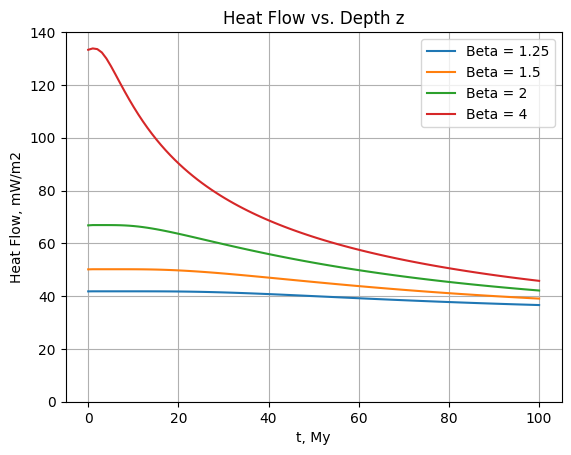

In [53]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def heat_flux(beta, t):

    # Define the variables and parameters
    a = 125
    tau = 62.8
    lam = 3.5
    # tau = (a**2*3.5)/np.pi**2
    print(tau)
    T1 = 1333
    N = 200  # Number of terms in the sum

    # Define the equation for T/Tm with z as a variable
    T_sum = 0
    for n in range(1, N+1):
        Cn = beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
        T_sum += Cn
    T_over_Tm = 0.8 * (1 + 2 * T_sum) # 0.8 = 34.5 mW/m2

    return T_over_Tm * 10**-3 * 60 * 697


beta_list = [1.25, 1.5, 2, 4]
t = np.linspace(0, 100, 100)

plt.figure()
for beta in beta_list:
    plt.plot(t, heat_flux(beta, t), label=f'Beta = {beta}')

plt.xlabel('t, My')
plt.ylabel('Heat Flow, mW/m2')
plt.title('Heat Flow vs. Depth z')
plt.grid(True)
plt.legend()
plt.ylim(0, 140)
plt.show()

In [54]:

a = 125 * 1000 #m an initial lithosphere thickness
k = 10**-6 #m2 s-1 thermal diffusivity of lithospheric rocks


tau = a**2/(k * np.pi**2)  # seconds!!!

# convert second to yaers, than to Million years
seconds = tau
years = seconds / 60 / 60 / 24 / 365.25  # Considering leap years
print(years * 10**-6)

50.166790073121135


In [55]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt


def heat_flow_fundament_calculation(beta, t, Q_const, constant=False):

  ###
  # concstant = True: постоянный тепловой поток Q_const
  # Q_const: значение постоянного теплового потока, mW/m2

  ###

  if constant == True:
    return Q_const

  else:

    def tau_heat_flux(a, k):

      tau = a**2/(k * np.pi**2) # [second]
      # convert second to yaers, than to Million years
      seconds = tau
      years = seconds / 60 / 60 / 24 / 365.25  # Considering leap years
      return years * 10**-6 # [Myr]


    def heat_flux(beta, t):

        # Define the variables and parameters of lithosphere

        a = 125 * 1000 #m an initial lithosphere thickness
        k = 10**-6 #m2 s-1 thermal diffusivity of lithospheric rocks

        tau = tau_heat_flux(a, k)
        # tau = 62.8 # Myr Lithospheric time constant
        lam = 3.5 #W/(mK)

        T1 = 1333
        N = 100 # Number of terms in the sum


        # Define the equation for F with z as a variable
        F_sum = 0
        for n in range(1, N+1):
            Cn = beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
            F_sum += Cn
        F_over_Tm = (lam*T1/a) * (1 + 2 * F_sum) # [mW/m2]
        return F_over_Tm

    return heat_flux(beta, t)

[0, 45, 55, 80, 100, 125, 145, 160, 210, 245, 260]
[np.float64(0.059907114944434986), np.float64(0.059907114944434986), np.float64(0.059907114944434986), np.float64(0.059907114944434986), np.float64(0.059907114944434986), np.float64(0.05127393891864027), np.float64(0.048890884798099096), np.float64(0.044430414591884876), np.float64(0.04210459554819064), np.float64(0.0402305843720639), np.float64(0.039275229959717106)]


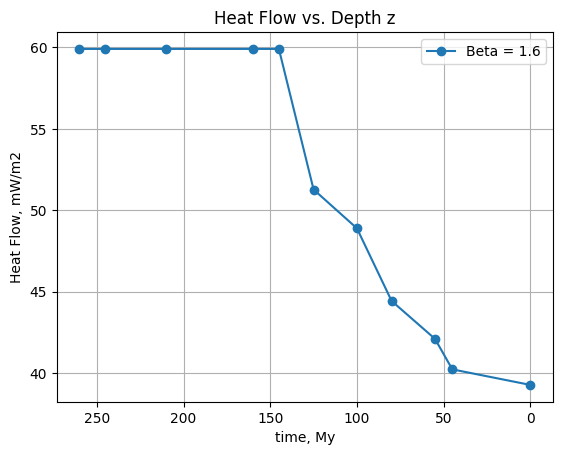

Age 0
0 Shales 200.0 200.0 0.039275229959717106
1 Sandstones 450.0 250.0 0.039275229959717106
2 Shales 1200.0 750.0 0.039275229959717106
3 Chalk 2500.0 1300.0 0.039275229959717106
4 Sandstones 3400.0 900.0 0.039275229959717106
5 Limestones 3600.0 200.0 0.039275229959717106
6 Dolomite 4000.0 400.0 0.039275229959717106
7 Sandstones 4250.0 250.0 0.039275229959717106
8 Anhydrite 5000.0 750.0 0.039275229959717106
9 Quartzite 5400.0 400.0 0.039275229959717106
Age 45
1 Sandstones 261.0 261.0 0.0402305843720639
2 Shales 1061.0 800.0 0.0402305843720639
3 Chalk 2391.0 1330.0 0.0402305843720639
4 Sandstones 3298.0 907.0 0.0402305843720639
5 Limestones 3499.0 201.0 0.0402305843720639
6 Dolomite 3900.0 401.0 0.0402305843720639
7 Sandstones 4151.0 251.0 0.0402305843720639
8 Anhydrite 4901.0 750.0 0.0402305843720639
9 Quartzite 5302.0 401.0 0.0402305843720639
Age 55
2 Shales 888.0 888.0 0.04210459554819064
3 Chalk 2262.0 1374.0 0.04210459554819064
4 Sandstones 3179.0 917.0 0.04210459554819064
5 Limes

In [56]:
T_with_rad_heat = pd.DataFrame()
T_without_rad_heat = pd.DataFrame()
T_linear_geotherm =  pd.DataFrame()
heat_flow = []

age_list = list(df_well['Age (Ma)'][1:])

print(age_list)

beta = 1.6
Qm_array = []
for t in age_list:
  if t <= 145:
    Qm_array.append(heat_flow_fundament_calculation(beta, t, Q_const=63*10**-3,
                                                    constant=False))
  else:
    Qm_array.insert(0, heat_flow_fundament_calculation(beta, 0, Q_const=63*10**-3,
                                                       constant=False))
print(Qm_array)
Qm_array = Qm_array[::-1]


plt.plot(age_list, [x * 10**3 for x in Qm_array], label=f'Beta = {beta}', marker='o')

plt.xlabel('time, My')
plt.ylabel('Heat Flow, mW/m2')
plt.title('Heat Flow vs. Depth z')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()
# plt.ylim(0, 140)
plt.show()
#  beta = stretch_factor_df[str(age)].iloc[0]


for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    T_list = []
    T_list_constant = []
    T_linear_geotherm_values = []

    T0 = 0
    G = 20

    print('Age', age)

    sum_variables_1, sum_variables_2 = [], []
    sum_variables_3, sum_variables_4 = [], []
    sum_variables_5 = []
    layers_sum = []
    heat_flow_list = []


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      A = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Radiogenic Heat Production'].iloc[0]
      K = tc_bulk_df.loc[row_index:].loc[tc_bulk_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]
      thickness_layer = decompaction_df.loc[row_index:].loc[decompaction_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000

      # K = tc.loc[row_index:].loc[tc['Lithology_type'] == str(lithology), f'{age}'].iloc[0] ### reference Table  A58.8

# ### Depth values
      depth = decompaction_corrected_df.loc[row_index:].loc[decompaction_corrected_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000
# ### Initial depth values
      y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

      layers_sum.append(thickness_layer)
      crust_depth = sum(layers_sum)
      Qm = Qm_array[i]


### With radio heat
      if K == 0:
        sum_variables_1.append(0)
        sum_variables_2.append(0)
      else:
        sum_variables_1.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_2.append((A/(2*K))*(thickness_layer)**2)


      T = T0 + (sum(sum_variables_1) - sum(sum_variables_2))
      T_list.append(T)
      heat_flow_list.append(Qm)

      # print(row_index, lithology, crust_depth, thickness_layer, Qm )

### without radio heat
      # Qm = 30*10**-3
      A = 0

      if K == 0:
        sum_variables_3.append(0)
      else:
        sum_variables_3.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_4.append((A/(2*K))*(thickness_layer)**2)

      T_no_heat = T0 + (sum(sum_variables_3) - sum(sum_variables_4))
      T_list_constant.append(T_no_heat)

      print(row_index, lithology, crust_depth, thickness_layer, Qm )

# ### Linear teady-stage geotherm Appendix 12
      T_linear_geotherm_values.append(linear_geotherm(G, depth/1000))

### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_with_rad_heat[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_list_constant
    new_col_values = resized_list_new
    T_without_rad_heat[new_col_name] = new_col_values


### Linear teady-stage geotherm Appendix 12
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_linear_geotherm_values
    new_col_values = resized_list_new
    T_linear_geotherm[new_col_name] = new_col_values


In [57]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
T_with_rad_heat['Event_name'] = work_layers['Event_name']
T_with_rad_heat['Lithology_type'] = work_layers['Lithology_type']
T_with_rad_heat = T_with_rad_heat[T_with_rad_heat.columns[::-1]]

T_with_rad_heat.to_csv('/content/T_with_rad_heat.csv', index=True)

In [58]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
T_without_rad_heat['Event_name'] = work_layers['Event_name']
T_without_rad_heat['Lithology_type'] = work_layers['Lithology_type']
T_without_rad_heat = T_without_rad_heat[T_without_rad_heat.columns[::-1]]

T_without_rad_heat.to_csv('/content/T_without_rad_heat.csv', index=True)

In [59]:
T_with_rad_heat

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.056392
1,Sandstones,Layer 9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.401438,10.256233
2,Shales,Layer 8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.042167,32.993054,37.544513
3,Chalk,Layer 7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.482508,75.685667,71.592281,74.437988
4,Sandstones,Layer 6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,19.291620,70.058508,89.110498,84.365786,86.872227
5,Limestones,Layer 5,0.0,0.000000,0.000000,0.000000,0.000000,6.939046,24.469963,74.290988,93.071135,88.162136,90.568193
6,Dolomite,Layer 4,0.0,0.000000,0.000000,0.000000,6.523144,12.359219,29.277250,78.523316,97.075322,91.998344,94.310875
7,Sandstones,Layer 3,0.0,0.000000,0.000000,7.607547,13.494899,18.089964,34.127368,82.597774,100.895515,95.648023,97.878577
8,Anhydrite,Layer 2,0.0,0.000000,7.683808,15.266443,21.129429,24.621362,40.320421,88.201895,106.207520,100.720739,102.833406
9,Quartzite,Layer 1,0.0,4.501865,12.012200,19.531434,25.332119,28.194918,43.662357,91.205836,109.055216,103.452478,105.500618


In [60]:
T_without_rad_heat

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.025980
1,Sandstones,Layer 9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.388249,10.194360
2,Shales,Layer 8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.442648,32.175787,36.541786
3,Chalk,Layer 7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.049599,74.472233,70.123785,72.752991
4,Sandstones,Layer 6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,19.010492,68.798798,86.931063,81.898273,84.159156
5,Limestones,Layer 5,0.0,0.000000,0.000000,0.000000,0.000000,6.928911,24.119810,72.901606,90.743236,85.540772,87.697465
6,Dolomite,Layer 4,0.0,0.000000,0.000000,0.000000,6.512838,12.326786,28.863123,77.018553,94.615700,89.240879,91.300697
7,Sandstones,Layer 3,0.0,0.000000,0.000000,7.577796,13.394713,17.935649,33.485591,80.746177,98.053087,92.499309,94.469077
8,Anhydrite,Layer 2,0.0,0.000000,7.678867,15.226784,21.013823,24.448249,39.646737,86.300902,103.310036,97.515592,99.366238
9,Quartzite,Layer 1,0.0,4.493034,11.971574,19.443176,25.153901,27.950880,42.885369,89.159165,105.998562,100.084455,101.867845


### Paleotemperature plots

[0, 45, 55, 80, 100, 125, 145, 160, 210, 245, 260]
[260, 245, 210, 160, 145, 125, 100, 80, 55, 45, 0]


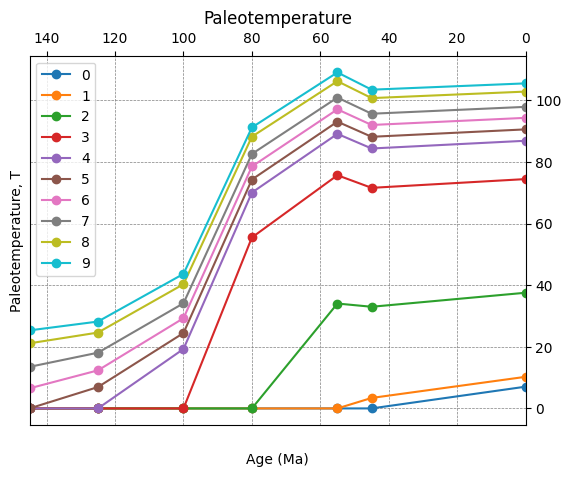

In [61]:
age_values  = [int(age) for age in df_well['Age (Ma)'][1:]]
print(age_values )
print(age_values[::-1])

values_for_plot = T_with_rad_heat.iloc[0:, 2:T_with_rad_heat.shape[1]]
# Transpose the DataFrame to iterate over rows instead of columns
for row_index, row in values_for_plot.iterrows():
  plt.plot(age_values, row[::-1], label=str(row_index), marker='o')

# Move the x-axis label to the top
plt.xlabel('Age (Ma)', labelpad=20)
plt.ylabel('Paleotemperature, T')

# Adjust tick parameters
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 145)
plt.gca().invert_xaxis()
plt.title("Paleotemperature")


# Display the plot
plt.show()

In [62]:
T_with_rad_heat.iloc[:, 2:T_with_rad_heat.shape[1]]

,260,245,210,160,145,125,100,80,55,45,0
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.056392
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.401438,10.256233
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.042167,32.993054,37.544513
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.482508,75.685667,71.592281,74.437988
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,19.291620,70.058508,89.110498,84.365786,86.872227
5,0.0,0.000000,0.000000,0.000000,0.000000,6.939046,24.469963,74.290988,93.071135,88.162136,90.568193
6,0.0,0.000000,0.000000,0.000000,6.523144,12.359219,29.277250,78.523316,97.075322,91.998344,94.310875
7,0.0,0.000000,0.000000,7.607547,13.494899,18.089964,34.127368,82.597774,100.895515,95.648023,97.878577
8,0.0,0.000000,7.683808,15.266443,21.129429,24.621362,40.320421,88.201895,106.207520,100.720739,102.833406
9,0.0,4.501865,12.012200,19.531434,25.332119,28.194918,43.662357,91.205836,109.055216,103.452478,105.500618


In [63]:
T_without_rad_heat

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.025980
1,Sandstones,Layer 9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.388249,10.194360
2,Shales,Layer 8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.442648,32.175787,36.541786
3,Chalk,Layer 7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.049599,74.472233,70.123785,72.752991
4,Sandstones,Layer 6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,19.010492,68.798798,86.931063,81.898273,84.159156
5,Limestones,Layer 5,0.0,0.000000,0.000000,0.000000,0.000000,6.928911,24.119810,72.901606,90.743236,85.540772,87.697465
6,Dolomite,Layer 4,0.0,0.000000,0.000000,0.000000,6.512838,12.326786,28.863123,77.018553,94.615700,89.240879,91.300697
7,Sandstones,Layer 3,0.0,0.000000,0.000000,7.577796,13.394713,17.935649,33.485591,80.746177,98.053087,92.499309,94.469077
8,Anhydrite,Layer 2,0.0,0.000000,7.678867,15.226784,21.013823,24.448249,39.646737,86.300902,103.310036,97.515592,99.366238
9,Quartzite,Layer 1,0.0,4.493034,11.971574,19.443176,25.153901,27.950880,42.885369,89.159165,105.998562,100.084455,101.867845


### McKenzie formula

In [64]:
T_true = pd.DataFrame()
F_true = pd.DataFrame()

age_list = list(df_well['Age (Ma)'][1:])
# age_list = list(df_well['Age (Ma)'][8:11])
print(age_list)

for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    T_list, heatflow = [], []

    Qm = -63*10**-3
    T0 = 0

    print('Age', age)

    # ### расчет corrected_decompaction for Fundament (not in work_layer)
    # if int(age) == age_list[-1]:
    #       T = 0
    #       T_list.append(T)
    #       T_list_constant.append(T)

    sum_variables_1, sum_variables_2 = [], []

### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      A = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Radiogenic Heat Production'].iloc[0]

      K = tc_bulk_df.loc[row_index:].loc[tc_bulk_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]

      work_layers_y = decompaction_df.drop(['Lithology_type'], axis=1, inplace=False)
      y = work_layers_y[f'{age}'].tail(1).iloc[0]

      depth = decompaction_corrected_df.loc[row_index:].loc[decompaction_corrected_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]

      l = decompaction_df.loc[row_index:].loc[decompaction_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]


      def temperature(z, t, tc):

        print(z, t, tc)

        # Define the variables and parameters
        beta = 1.7
        a = 125
        # tau = (a**2 * tc)/np.pi**2
        tau = 50
        T1 = 1330
        N = 10  # Number of terms in the sum

        # Define the equation for T/Tm with z as a variable
        T_sum = 0
        for n in range(1, N+1):
            Cn = (-1)**(n+1)/(n) * beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau) * np.sin(n*np.pi*z/a)
            T_sum += Cn
        T_over_Tm = T0 + (1-z/a + 2/np.pi*T_sum*T1)

        return T_over_Tm

      T_list.append(temperature(depth, age, K))


      def heat_flux(beta, t, tc):

        # Define the variables and parameters
        a = 125
        tau = 62.8
        T1 = 1333
        N = 50  # Number of terms in the sum

        # Define the equation for T/Tm with z as a variable
        T_sum = 0
        for n in range(1, N+1):
            Cn = beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
            T_sum += Cn
        T_over_Tm = K*T1/a * (1 + 2 * T_sum)

        return T_over_Tm

      beta = 1.7
      heatflow.append(heat_flux(beta, age, K))

      # print(row_index, lithology, layers_name, y, l, K, T_list)


# ### without radio heat
#       if K == 0:
#         sum_variables_3.append(0)
#       else:
#         sum_variables_3.append(l*1000/K)

#       T_no_heat = T0 - Qm*sum(sum_variables_3)
#       T_list_constant.append(T_no_heat)

#       print(row_index, lithology, layers_name, y, l, K)


# ### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_true[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(heatflow):] = heatflow
    new_col_values = resized_list_new
    F_true[new_col_name] = new_col_values

[0, 45, 55, 80, 100, 125, 145, 160, 210, 245, 260]
Age 0
0.4999999999999993 0 1.1179999999999999
0.75 0 3.099
1.4999999999999998 0 1.1179999999999999
2.8 0 1.4100000000000001
3.7 0 3.099
3.9000000000000004 0 2.2199999999999998
4.3 0 4.36
4.549999999999999 0 3.099
5.299999999999999 0 6.015
5.699999999999999 0 6.28
Age 45
0.5290830462071514 45 3.099
1.3291887380071339 45 1.1179999999999999
2.659257053491877 45 1.4100000000000001
3.5666660576986455 45 3.099
3.7673096278662666 45 2.2199999999999998
4.167828392805276 45 4.36
4.419135740953499 45 3.099
5.1694374379485915 45 6.015
5.569961569430558 45 6.28
Age 55
1.1659014066130473 55 1.1179999999999999
2.5394442416637926 55 1.4100000000000001
3.4562127720134876 55 3.099
3.6576874103314116 55 2.2199999999999998
4.0588725942623265 55 4.36
4.311812426767575 55 3.099
5.062483789065788 55 6.015
5.4636582646982745 55 6.28
Age 80
1.9038426763530225 80 1.4100000000000001
2.8627821675391156 80 3.099
3.0682226174937983 80 2.2199999999999998
3.47253470

In [65]:
T_true

,0,45,55,80,100,125,145,160,210,245,260
0,6.055821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,8.584900,3.421555,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,16.182348,7.082546,5.331649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,29.416517,13.161950,10.429528,5.249944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,38.652564,17.301697,13.826032,7.387475,2.923847,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,40.715276,18.215939,14.571591,7.844969,3.270209,1.197912,0.000000,0.000000,0.000000,0.000000,0.0
6,44.853088,20.039515,16.055093,8.744778,3.901248,1.611386,1.331838,0.000000,0.000000,0.000000,0.0
7,47.448014,21.182700,16.989612,9.323071,4.338409,1.916990,1.546011,1.191028,0.000000,0.000000,0.0
8,55.276061,24.590548,19.758989,10.993774,5.466777,2.604712,2.005959,1.531551,1.125010,0.000000,0.0
9,59.478903,26.406177,21.236242,11.889532,6.085128,2.991105,2.266419,1.727254,1.196121,1.035079,0.0


In [66]:
F_true

,0,45,55,80,100,125,145,160,210,245,260
0,20.172499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,55.916434,49.301633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,20.172499,17.786133,16.988354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,25.441166,22.431527,21.425384,19.388450,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,55.916434,49.301633,47.090258,42.613337,40.030271,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,40.056303,35.317723,33.733583,30.526495,28.676090,27.038851,0.000000,0.000000,0.000000,0.000000,0.0
6,78.669137,69.362736,66.251541,59.952936,56.318807,53.103330,51.303050,0.000000,0.000000,0.000000,0.0
7,55.916434,49.301633,47.090258,42.613337,40.030271,37.744775,36.465173,35.739441,0.000000,0.000000,0.0
8,108.530930,95.691940,91.399774,82.710301,77.696703,73.260672,70.777029,69.368420,66.500731,0.000000,0.0
9,113.312426,99.907794,95.426531,86.354229,81.119749,76.488282,73.895219,72.424552,69.430522,68.379217,0.0


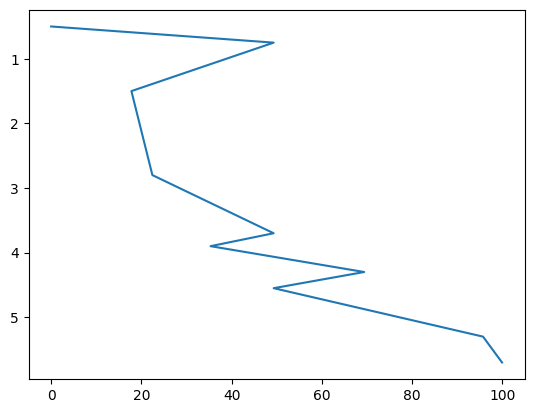

In [67]:
plt.plot(F_true['45'], decompaction_corrected_df['0'], label='McKenzie')
plt.gca().invert_yaxis()

10 10


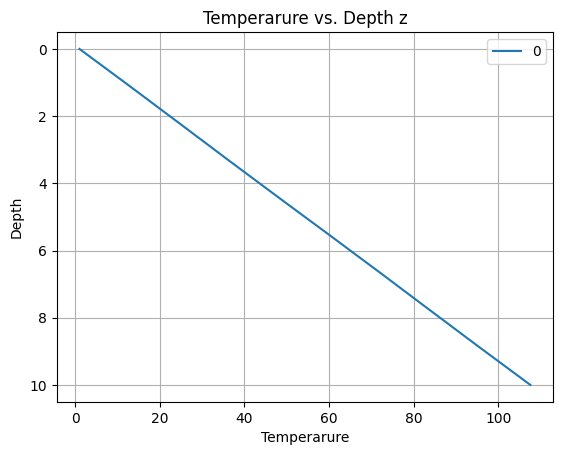

In [68]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def temperature(z, t):

    # Define the variables and parameters
    beta = 10
    a = 125
    tc = 3
    tau = (a**2 * tc)/np.pi**2
    T1 = 1333
    N = 50  # Number of terms in the sum

    # Define the equation for T/Tm with z as a variable
    T_sum = 0
    for n in range(1, N+1):
        Cn = (-1)**(n+1)/(n) * beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau) * np.sin(n*np.pi*z/a)
        T_sum += Cn
    T_over_Tm = 1-z/a + 2/np.pi*T_sum*T1

    return T_over_Tm

beta_list = [0, 1, 2, 3, 4, 5]
depth_list = np.linspace(0, 10, 10)
t = 0

temp = []

plt.figure()
for depth in depth_list:
    temp.append(temperature(depth, t))
    # plt.plot(depth, temperature(depth, t))

print(len(depth_list), len(temp))

plt.ylabel('Depth')
plt.xlabel('Temperarure')
plt.title('Temperarure vs. Depth z')
plt.plot(temp, depth_list, label=t)
plt.grid(True)
plt.legend()
plt.gca().invert_yaxis()  # Invert the y-axis
# plt.ylim(0, 3)
plt.show()

In [69]:
initial_depth_values

[np.float64(0.0),
 np.float64(0.2),
 np.float64(0.45),
 np.float64(1.2),
 np.float64(2.5),
 np.float64(3.4),
 np.float64(3.6),
 np.float64(4.0),
 np.float64(4.25),
 np.float64(5.0)]

### Plot

In [70]:
tc_bulk_df

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.118
1,Sandstones,Layer 9,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.099,3.099
2,Shales,Layer 8,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,1.118,1.118,1.118
3,Chalk,Layer 7,0.0,0.00,0.000,0.000,0.000,0.000,0.000,1.410,1.410,1.410,1.410
4,Sandstones,Layer 6,0.0,0.00,0.000,0.000,0.000,0.000,3.099,3.099,3.099,3.099,3.099
5,Limestones,Layer 5,0.0,0.00,0.000,0.000,0.000,2.220,2.220,2.220,2.220,2.220,2.220
6,Dolomite,Layer 4,0.0,0.00,0.000,0.000,4.360,4.360,4.360,4.360,4.360,4.360,4.360
7,Sandstones,Layer 3,0.0,0.00,0.000,3.099,3.099,3.099,3.099,3.099,3.099,3.099,3.099
8,Anhydrite,Layer 2,0.0,0.00,6.015,6.015,6.015,6.015,6.015,6.015,6.015,6.015,6.015
9,Quartzite,Layer 1,0.0,6.28,6.280,6.280,6.280,6.280,6.280,6.280,6.280,6.280,6.280


In [71]:
T0 = 0
Linear = T_linear_geotherm["0"].tolist()
Linear.insert(0, T0)


A_line = T_without_rad_heat["0"].tolist()
A_line.insert(0, T0)

C_line = T_with_rad_heat["0"].tolist()
C_line.insert(0, T0)

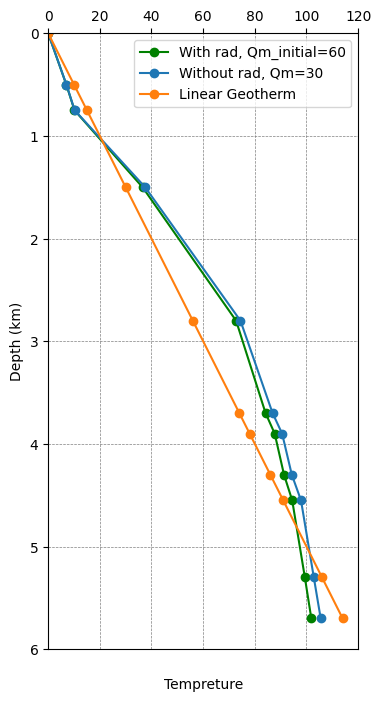

In [72]:
plt.figure(figsize=(4, 8))
plt.plot(A_line, [0]+decompaction_corrected_df['0'].tolist(), label='With rad, Qm_initial=60', marker='o', color='green')
plt.plot(C_line, [0]+decompaction_corrected_df['0'].tolist(), label='Without rad, Qm=30', marker='o')
# plt.plot(T_true['0'], decompaction_corrected_df['0'], label='McKenzie')
plt.plot(Linear, [0]+decompaction_corrected_df['0'].tolist(), label='Linear Geotherm', marker='o')

# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Tempreture', labelpad=20)
plt.ylabel(f'Depth (km)')
# plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 120)
plt.ylim(0, 6)
plt.gca().invert_yaxis()
plt.show()

In [73]:
lithology_numbers = {30000: {'lith':'Sandstones', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                 65030: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 65000: {'lith':'Shales', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                 80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 74000: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                 70000: {'lith':'Limestones', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 70032: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                 99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 90000: {'lith':'Quartzite', 'lith_num':11, 'hatch':'', 'color':'black'},
                 93000: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

In [74]:
T_with_rad_heat["Lithology"] = ['65000', '30000', '65000', '70032', '30000', '70000', '74000', '30000', '86000', '90000']
T_with_rad_heat["Lithology"] = T_with_rad_heat["Lithology"].astype(int)

In [75]:
T_with_rad_heat["Lithology"] = T_with_rad_heat["Lithology"].astype(int)

In [76]:
T_with_rad_heat

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0,Lithology
0,Shales,Layer 10,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.056392,65000
1,Sandstones,Layer 9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.401438,10.256233,30000
2,Shales,Layer 8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.042167,32.993054,37.544513,65000
3,Chalk,Layer 7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.482508,75.685667,71.592281,74.437988,70032
4,Sandstones,Layer 6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,19.291620,70.058508,89.110498,84.365786,86.872227,30000
5,Limestones,Layer 5,0.0,0.000000,0.000000,0.000000,0.000000,6.939046,24.469963,74.290988,93.071135,88.162136,90.568193,70000
6,Dolomite,Layer 4,0.0,0.000000,0.000000,0.000000,6.523144,12.359219,29.277250,78.523316,97.075322,91.998344,94.310875,74000
7,Sandstones,Layer 3,0.0,0.000000,0.000000,7.607547,13.494899,18.089964,34.127368,82.597774,100.895515,95.648023,97.878577,30000
8,Anhydrite,Layer 2,0.0,0.000000,7.683808,15.266443,21.129429,24.621362,40.320421,88.201895,106.207520,100.720739,102.833406,86000
9,Quartzite,Layer 1,0.0,4.501865,12.012200,19.531434,25.332119,28.194918,43.662357,91.205836,109.055216,103.452478,105.500618,90000


In [77]:
df_lith = pd.DataFrame.from_dict(lithology_numbers, orient='index')
df_lith.index.name = 'LITHOLOGY'
df_lith

,lith,lith_num,hatch,color
LITHOLOGY,,,,
30000,Sandstones,1,..,#ffff00
65030,Sandstone/Shale,2,-.,#ffe119
65000,Shales,3,--,#bebebe
80000,Marl,4,,#7cfc00
74000,Dolomite,5,-/,#8080ff
70000,Limestones,6,+,#80ffff
70032,Chalk,7,..,#80ffff
88000,Halite,8,x,#7ddfbe
86000,Anhydrite,9,,#ff80ff


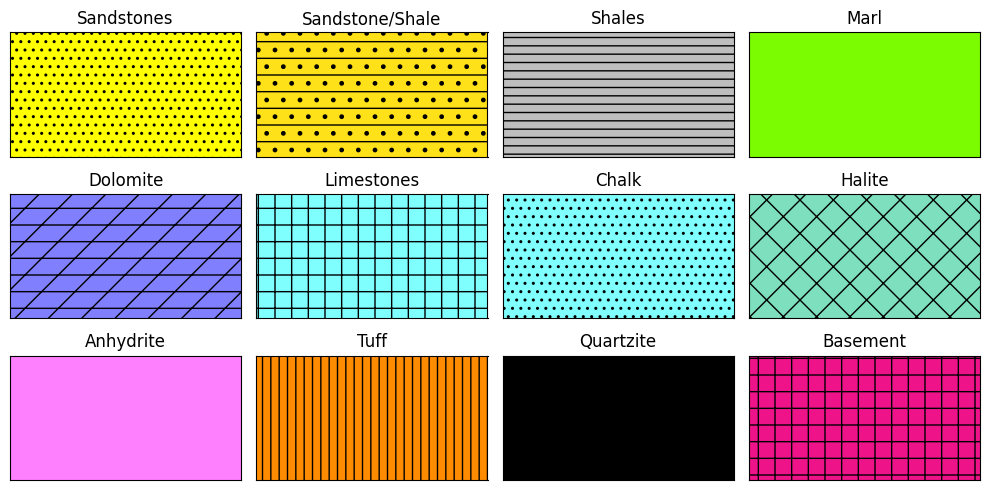

In [78]:
y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=4,nrows=3, sharex=True, sharey=True,
                         figsize=(10,5), subplot_kw={'xticks': [], 'yticks': []})

for ax, key in zip(axes.flat, lithology_numbers.keys()):
    ax.plot(x, y)
    ax.fill_betweenx(y, 0, 1, facecolor=lithology_numbers[key]['color'], hatch=lithology_numbers[key]['hatch'])
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 1)
    ax.set_title(str(lithology_numbers[key]['lith']))

plt.tight_layout()

plt.show()

In [79]:

def makeplot(well, top_depth, bottom_depth):
    # fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    # ax = fig.subplots(1, 2,  sharex=False)

    fig, ax = plt.subplots(figsize=(14,7))

    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

### Plot 1
    # Geotherma
    ax1.plot(T_with_rad_heat['0'], decompaction_corrected_df['0'], label='with rad')
    # ax1.plot(table2['0'],decompaction_corrected_df['0'], label='without rad')
    # ax1.plot(T_true['0'], decompaction_corrected_df['0'], label='McKenzie')
    ax1.set_xlabel(f'Tempreture', labelpad=20)
    ax1.set_ylabel(f'Depth (km)')
    ax1.legend()

### Plot 2
    # Lithology track
    # ax2.plot(T_with_rad_heat["Lithology"], T_with_rad_heat['depth 0'], color = "black", linewidth = 0.5)
    ax2.set_xlabel("Lithology")
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(T_with_rad_heat["Lithology"], decompaction_corrected_df['0']):
        key = int(lit)
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']

        depth_values = [depth_start, depth]
        depth_start = depth

        ax2.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch)

    ax2.set_xticks([0, 1])

### Plot3
    ax3.set_xlabel("Lithology")
    ax3.set_xlim(0, 1)
    ax3.xaxis.label.set_color("black")
    ax3.tick_params(axis='x', colors="black")
    ax3.spines["top"].set_edgecolor("black")
    ax3.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(T_with_rad_heat["Lithology_type"], decompaction_corrected_df['0']):
        key = lit
        depth_values = [depth_start, depth]
        depth_start = depth

        label_position = (0.5, sum(depth_values) / 2)  # Assuming x position is at 0.5
        ax3.text(label_position[0], label_position[1], key, ha='center', va='center')
        ax3.plot([0, 1], [depth, depth], color='black', linewidth=1)  # Assuming black color and linewidth of 1



    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

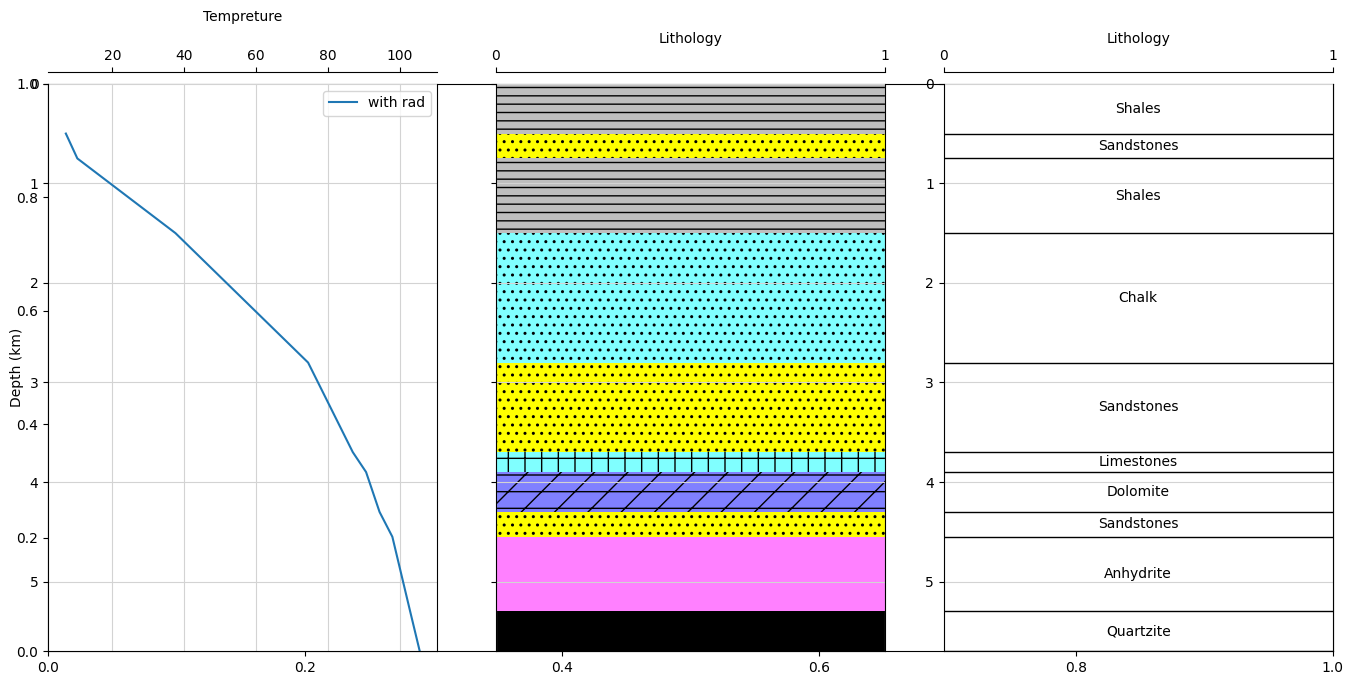

In [80]:
makeplot(T_with_rad_heat, 0, max(decompaction_corrected_df['0']))

## Step 7. Calculation of the stretch factor

In [81]:
import warnings
from scipy import stats

warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

In [82]:
from scipy.stats import linregress
from scipy.optimize import fsolve

In [83]:
# Define beta=stretch factor
def stretch_factor(beta):
  return E0 * (beta/np.pi) * np.sin(np.pi/beta) - slope


stretch_factor_df = pd.DataFrame()

tau = 50

for age in output_df.columns:
    col_list = output_df[age].tolist()
    thermal_subsidenence = col_list[::-1]
    non_zero_values = [value for value in thermal_subsidenence if value != 0]
    time = np.array(df_well['Age (Ma)'][1:len(non_zero_values)+1])

    x = 1-np.exp(-time/tau)
    y = list(map(lambda x: x * 1000, non_zero_values))

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate E0

    # Constant value - pp.497 (pdf), Table A19.1
    Tm = 1330
    yl = 125
    alpha_v =3.28*10**-5 #CLTE
    RoWater, RoMantle = 1030, 3300

    # # Example from book
    # slope, E0 = 1368, 3212

    E0 = (4*yl*RoMantle*alpha_v*Tm)/(np.pi**2*(RoMantle - RoWater))*1000 # [m]

    beta = fsolve(stretch_factor, 1.0)[0]

    # print(age, f"The value of beta is: {beta:.2f}")

    # Save results in table
    new_col_name = f'{age}'
    stretch_factor_df[new_col_name] = [beta]

/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:10750: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
<ipython-input-83-026e1e7364fa>:35: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  beta = fsolve(stretch_factor, 1.0)[0]
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t

In [84]:
stretch_factor_df.to_csv('/content/Stretch_factor.csv', index=True)

In [85]:
stretch_factor_df

,260,245,210,160,145,125,100,80,55,45,0
0,1.0,1.0,1.135525,1.19758,1.221447,1.246555,1.454166,1.822544,1.970152,2.030505,1.984391


/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:10750: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


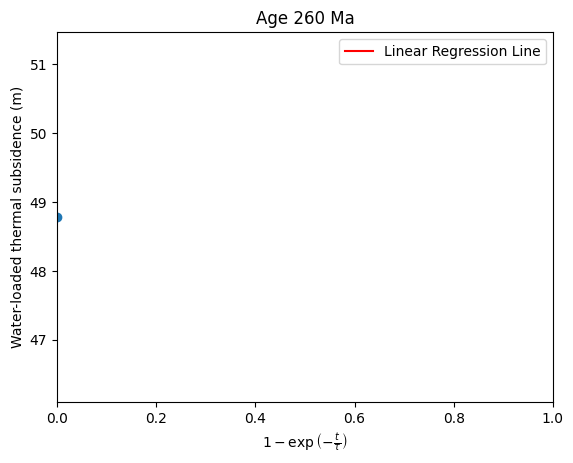

Equation of the linear regression line: y = nanx + nan
R coefficient: 0.00
Slope: nan [m]


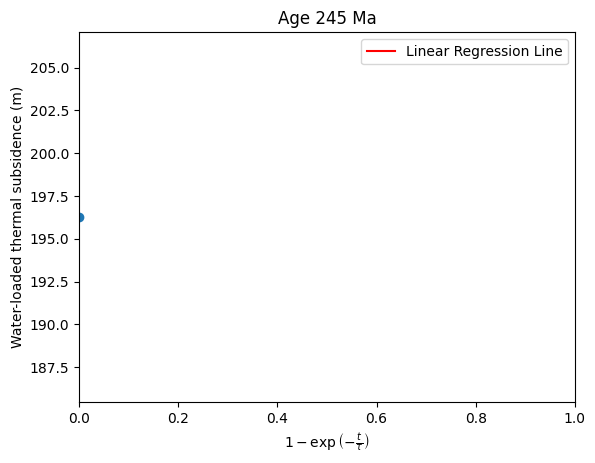

Equation of the linear regression line: y = nanx + nan
R coefficient: 0.00
Slope: nan [m]


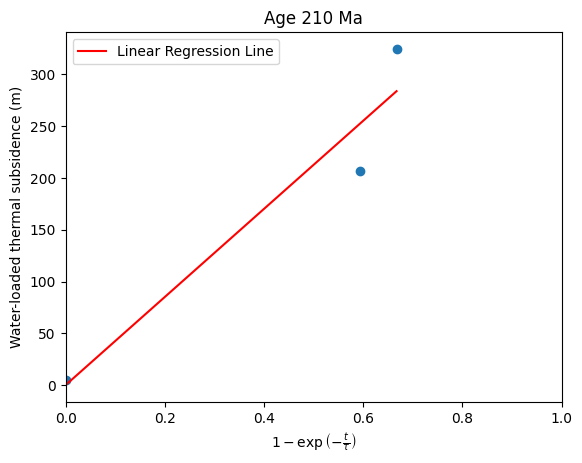

Equation of the linear regression line: y = 425.28x + 0.18
R coefficient: 0.96
Slope: 425.28 [m]


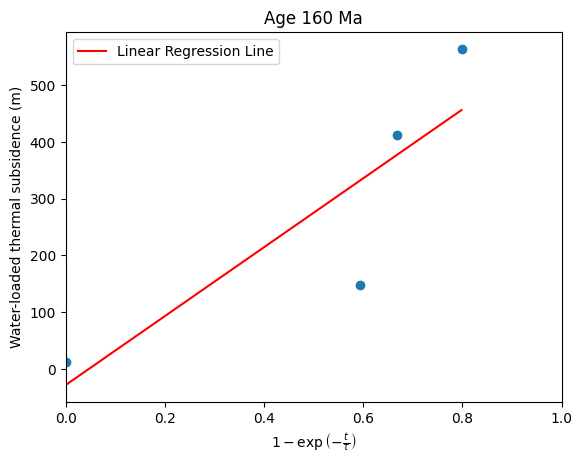

Equation of the linear regression line: y = 606.74x + -28.11
R coefficient: 0.86
Slope: 606.74 [m]


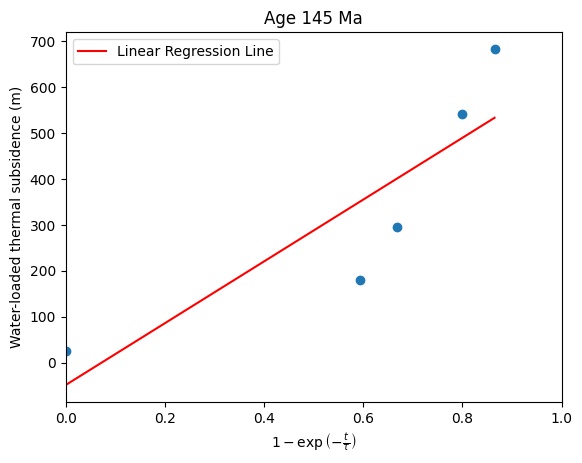

Equation of the linear regression line: y = 673.62x + -48.86
R coefficient: 0.87
Slope: 673.62 [m]


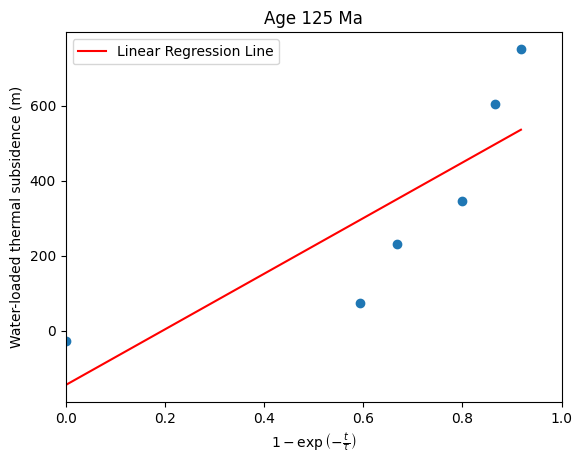

Equation of the linear regression line: y = 742.13x + -144.96
R coefficient: 0.83
Slope: 742.13 [m]


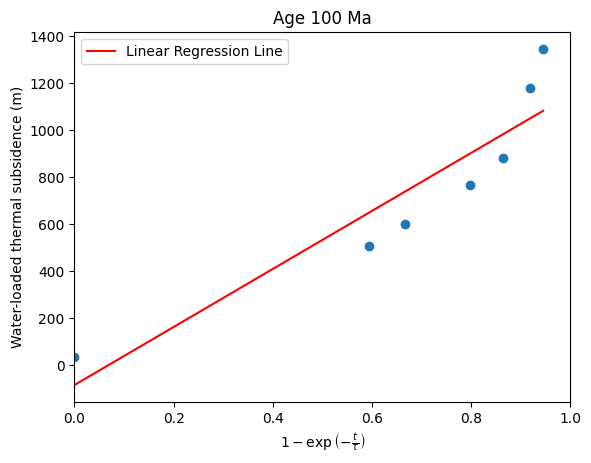

Equation of the linear regression line: y = 1236.03x + -84.98
R coefficient: 0.92
Slope: 1236.03 [m]


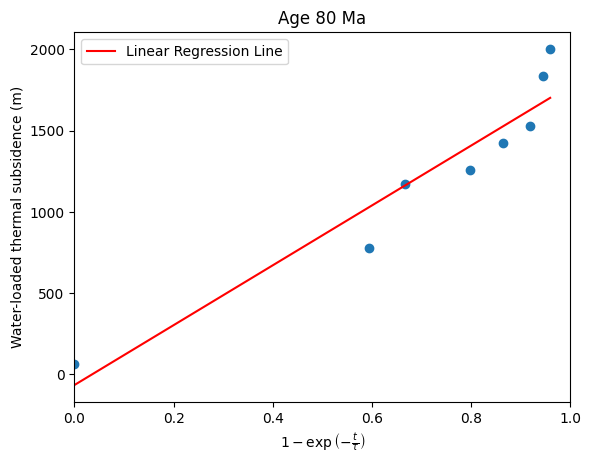

Equation of the linear regression line: y = 1842.10x + -65.08
R coefficient: 0.95
Slope: 1842.10 [m]


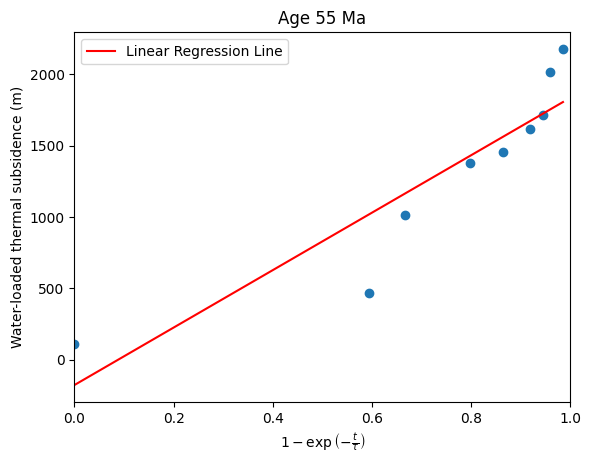

Equation of the linear regression line: y = 2014.24x + -178.13
R coefficient: 0.91
Slope: 2014.24 [m]


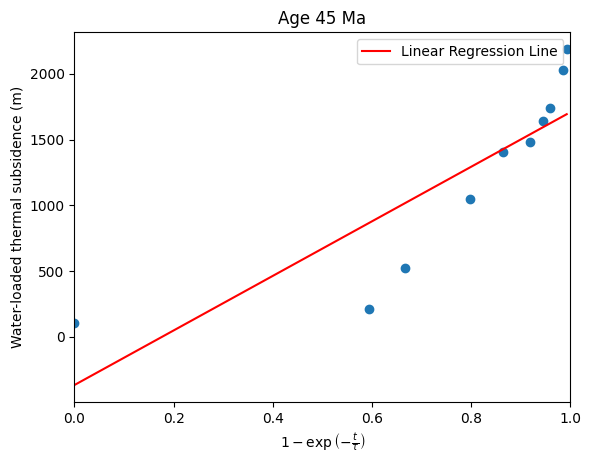

Equation of the linear regression line: y = 2075.95x + -367.92
R coefficient: 0.85
Slope: 2075.95 [m]


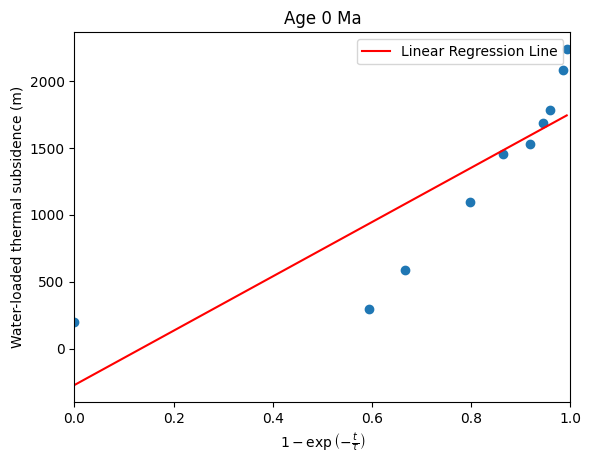

Equation of the linear regression line: y = 2029.21x + -270.93
R coefficient: 0.85
Slope: 2029.21 [m]


In [86]:
for age in output_df.columns:
    col_list = output_df[age].tolist()
    thermal_subsidence = col_list[::-1]
    non_zero_values = [val for val in thermal_subsidence if val != 0]

    tau = 50
    time = np.array(df_well['Age (Ma)'][1:len(non_zero_values)+1])

    x = 1 - np.exp(-time/tau)
    y = list(map(lambda x: x * 1000, non_zero_values))

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the regression line
    regression_line = slope * x + intercept

    plt.scatter(x, y)
    plt.plot(x, regression_line, color='red', label='Linear Regression Line')
    plt.xlim(0, 1)
    plt.legend(loc='best')
    plt.title(f'Age {age} Ma')
    plt.xlabel(r'$1 - \exp\left(-\frac{t}{\tau}\right)$')
    plt.ylabel(r'Water-loaded thermal subsidence (m)')

    plt.show()

    # Print the equation of the linear regression line and the R coefficient
    print(f"Equation of the linear regression line: y = {slope:.2f}x + {intercept:.2f}")
    print(f"R coefficient: {r_value:.2f}")
    print(f"Slope: {slope:.2f} [m]")

In [87]:
beta = stretch_factor_df["0"].iloc[0] # Значение, используемое для следующих расчетов
beta

np.float64(1.984390911840124)

## Step 8. Calculation of paleotemperatures using the reference uniform stretching model



#### Heat Flow: subsiding only

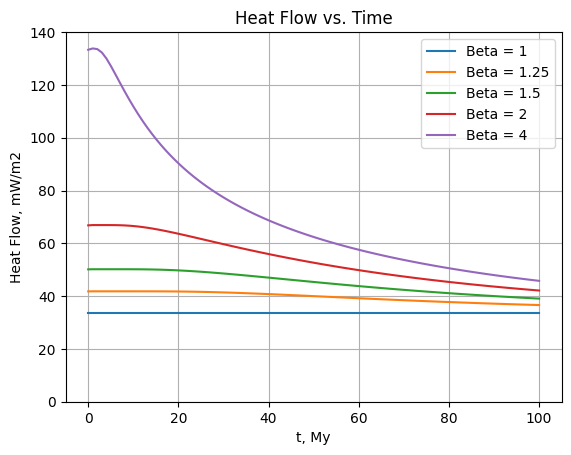

In [88]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def heat_flux(beta, t):

    # Define the variables and parameters
    a = 125
    tau = 62.8
    lam = 3.5
    T1 = 1333
    N = 200  # Number of terms in the sum

    # Define the equation for T/Tm with z as a variable
    T_sum = 0
    for n in range(1, N+1):
        Cn = beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
        T_sum += Cn
    T_over_Tm = 0.8 * (1 + 2 * T_sum) # 0.8 = 34.5 mW/m2

    return T_over_Tm * 10**-3 * 60 * 697


beta_list = [1, 1.25, 1.5, 2, 4]
t = np.linspace(0, 100, 100)

plt.figure()
for beta in beta_list:
    plt.plot(t, heat_flux(beta, t), label=f'Beta = {beta}')

plt.xlabel('t, My')
plt.ylabel('Heat Flow, mW/m2')
plt.title('Heat Flow vs. Time')
plt.grid(True)
plt.legend()
plt.ylim(0, 140)
plt.show()

#### Temperature calculation (variable Heat Flow (F) for diffrent age)

In [89]:
# import numpy as np
# import sympy as sp
# import matplotlib.pyplot as plt


def heat_flow_fundament_calculation(beta, t, Q_const, constant=False):

  ###
  # concstant = True: постоянный тепловой поток Q_const
  # Q_const: значение постоянного теплового потока, mW/m2

  ###

  if constant == True:
    return Q_const

  else:

    def tau_heat_flux(a, k):
      tau = a**2/(k * np.pi**2) # [second]
      # convert second to yaers, than to Million years
      seconds = tau
      years = seconds / 60 / 60 / 24 / 365.25  # Considering leap years
      return years * 10**-6 # [Myr]


    def heat_flux(beta, t):

        # Define the variables and parameters of lithosphere
        a = 125 * 1000 #m an initial lithosphere thickness
        k = 10**-6 #m2 s-1 thermal diffusivity of lithospheric rocks

        tau = tau_heat_flux(a, k)  # Myr Lithospheric time constant
        # tau = 62.8
        lam = 3.5 # Lithospheric thermal conductivity [W/mK]

        T1 = 1333
        N = 100 # Number of terms in the sum

        # Define the equation for F with z as a variable
        F_sum = 0
        for n in range(1, N+1):
            Cn = beta / (n * np.pi) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
            F_sum += Cn
        F_over_Tm = (lam*T1/a) * (1 + 2 * F_sum) # [mW/m2]
        return F_over_Tm

    return heat_flux(beta, t)

[np.float64(0.039275229959717106), np.float64(0.0402305843720639), np.float64(0.04210459554819064), np.float64(0.044430414591884876), np.float64(0.048890884798099096), np.float64(0.05127393891864027), np.float64(0.059907114944434986), np.float64(0.059907114944434986), np.float64(0.059907114944434986), np.float64(0.059907114944434986), np.float64(0.059907114944434986)]


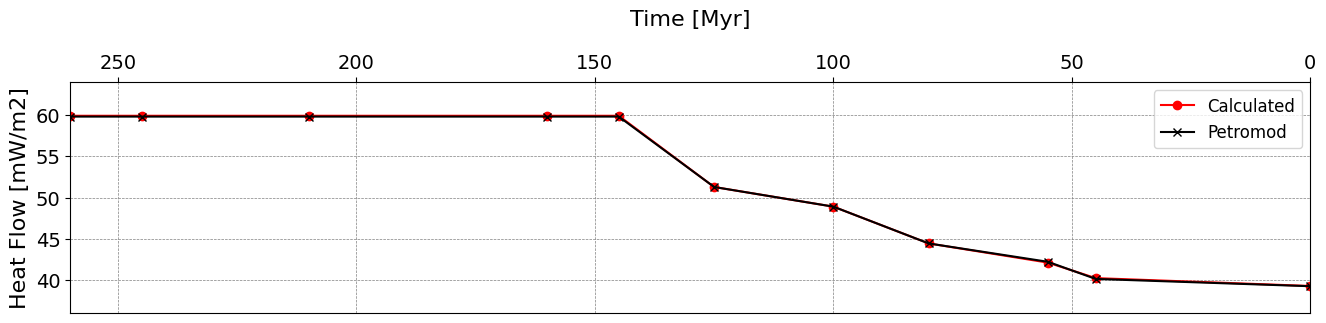

Age 0
0 Shales 200.0 200.0 0.039275229959717106
1 Sandstones 450.0 250.0 0.039275229959717106
2 Shales 1200.0 750.0 0.039275229959717106
3 Chalk 2500.0 1300.0 0.039275229959717106
4 Sandstones 3400.0 900.0 0.039275229959717106
5 Limestones 3600.0 200.0 0.039275229959717106
6 Dolomite 4000.0 400.0 0.039275229959717106
7 Sandstones 4250.0 250.0 0.039275229959717106
8 Anhydrite 5000.0 750.0 0.039275229959717106
9 Quartzite 5400.0 400.0 0.039275229959717106
Age 45
1 Sandstones 261.0 261.0 0.0402305843720639
2 Shales 1061.0 800.0 0.0402305843720639
3 Chalk 2391.0 1330.0 0.0402305843720639
4 Sandstones 3298.0 907.0 0.0402305843720639
5 Limestones 3499.0 201.0 0.0402305843720639
6 Dolomite 3900.0 401.0 0.0402305843720639
7 Sandstones 4151.0 251.0 0.0402305843720639
8 Anhydrite 4901.0 750.0 0.0402305843720639
9 Quartzite 5302.0 401.0 0.0402305843720639
Age 55
2 Shales 888.0 888.0 0.04210459554819064
3 Chalk 2262.0 1374.0 0.04210459554819064
4 Sandstones 3179.0 917.0 0.04210459554819064
5 Limes

In [133]:
T_with_rad_heat = pd.DataFrame()
T_without_rad_heat = pd.DataFrame()
T_linear_geotherm =  pd.DataFrame()
age_list = list(df_well['Age (Ma)'][1:])

# Heat flow
heat_flow = []

# print(age_list)

beta = 1.6
Qm_array = []
for t in age_list:
  if t <= 145:
    Qm_array.append(heat_flow_fundament_calculation(beta, t, Q_const=63*10**-3,
                                                    constant=False))
  else:
    Qm_array.insert(0, heat_flow_fundament_calculation(beta, 0, Q_const=63*10**-3,
                                                       constant=False))

Qm_Petromod = [0.039245229959717106,
 0.0401305843720639,
 0.04220459554819064,
 0.044430414591884876,
 0.048890884798099096,
 0.05127393891864027,
 0.059807114944434986,
 0.059807114944434986,
 0.059807114944434986,
 0.059807114944434986,
 0.059807114944434986]


#  [0.039275229959717106,
#  0.0402305843720639,
#  0.04210459554819064,
#  0.044430414591884876,
#  0.048890884798099096,
#  0.05127393891864027,
#  0.059907114944434986,
#  0.059907114944434986,
#  0.059907114944434986,
#  0.059907114944434986,
#  0.059907114944434986]



# print(Qm_array)
Qm_array = Qm_array[::-1]
print(Qm_array)

plt.figure(figsize=(16, 3))
plt.plot(age_list, [x * 10**3 for x in Qm_array],
         label=f'Calculated',
         marker='o',
         color='red')
plt.plot(age_list, [x * 10**3 for x in Qm_Petromod ],
         label=f'Petromod',
         marker='x',
         color='black')

# plt.xlabel('time, My')
# plt.ylabel('Heat Flow, mW/m2')
# plt.title('Heat Flow vs. Time')
# plt.grid(True)
# plt.legend()
# plt.gca().invert_xaxis()


plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

ax = plt.gca()
ax.xaxis.set_label_position('top')  # Move x-axis label to top
ax.set_xlabel('Time [Myr]', labelpad=20, fontsize=16)
ax.set_ylabel('Heat Flow [mW/m2]', fontsize=16)

plt.xticks(fontsize=14)  # Increase x-axis tick label size
plt.yticks(fontsize=14)  # Increase y-axis tick label size

plt.legend(fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 260)
plt.ylim(36, 64)
plt.gca().invert_xaxis()
plt.savefig('HeatFlow.png', dpi=300, bbox_inches='tight')
plt.show()
# plt.ylim(0, 140)


#  beta = stretch_factor_df[str(age)].iloc[0]

# Calculation for each age
for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    T_list = []
    T_list_constant = []
    T_linear_geotherm_values = []

    T0 = 0
    G = 20

    print('Age', age)

    sum_variables_1, sum_variables_2 = [], []
    sum_variables_3, sum_variables_4 = [], []
    sum_variables_5 = []
    layers_sum = []
    heat_flow_list = []


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      A = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Radiogenic Heat Production'].iloc[0]
      K = tc_bulk_df.loc[row_index:].loc[tc_bulk_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]
      thickness_layer = decompaction_df.loc[row_index:].loc[decompaction_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000

      # K = tc.loc[row_index:].loc[tc['Lithology_type'] == str(lithology), f'{age}'].iloc[0] ### reference Table  A58.8

# ### Depth values
      depth = decompaction_corrected_df.loc[row_index:].loc[decompaction_corrected_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]*1000
# ### Initial depth values
      y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

      layers_sum.append(thickness_layer)
      crust_depth = sum(layers_sum)
      Qm = Qm_array[i]


### With radio heat
      if K == 0:
        sum_variables_1.append(0)
        sum_variables_2.append(0)
      else:
        sum_variables_1.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_2.append((A/(2*K))*(thickness_layer)**2)


      T = T0 + (sum(sum_variables_1) - sum(sum_variables_2))
      T_list.append(T)
      heat_flow_list.append(Qm)

      print(row_index, lithology, crust_depth, thickness_layer, Qm )

### without radio heat
      # Qm = 63*10**-3
      A = 0

      if K == 0:
        sum_variables_3.append(0)
      else:
        sum_variables_3.append(((Qm+A*crust_depth)/K)*thickness_layer)
        sum_variables_4.append((A/(2*K))*(thickness_layer)**2)

      T_no_heat = T0 + (sum(sum_variables_3) - sum(sum_variables_4))
      T_list_constant.append(T_no_heat)

      # print(row_index, lithology, crust_depth, thickness_layer, Qm )

# ### Linear teady-stage geotherm Appendix 12
      T_linear_geotherm_values.append(linear_geotherm(G, depth/1000))

### Save results in table

### with radio heat
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_with_rad_heat[new_col_name] = new_col_values

### without radio heat
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_list_constant
    new_col_values = resized_list_new
    T_without_rad_heat[new_col_name] = new_col_values


### Linear teady-stage geotherm Appendix 12
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list_constant):] = T_linear_geotherm_values
    new_col_values = resized_list_new
    T_linear_geotherm[new_col_name] = new_col_values


In [91]:
save_to_csv(T_with_rad_heat, work_layers, "Geotherm_with_A")
save_to_csv(T_without_rad_heat, work_layers, "Geotherm_without_A")
save_to_csv(T_linear_geotherm, work_layers, "Linear_Geotherm")

In [ ]:
# ### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
# T_with_rad_heat['Event_name'] = work_layers['Event_name']
# T_with_rad_heat['Lithology_type'] = work_layers['Lithology_type']
# T_with_rad_heat = T_with_rad_heat[T_with_rad_heat.columns[::-1]]

# T_with_rad_heat.to_csv('/content/T_with_rad_heat.csv', index=True)

In [ ]:
# ### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
# T_without_rad_heat['Event_name'] = work_layers['Event_name']
# T_without_rad_heat['Lithology_type'] = work_layers['Lithology_type']
# T_without_rad_heat = T_without_rad_heat[T_without_rad_heat.columns[::-1]]

# T_without_rad_heat.to_csv('/content/T_without_rad_heat.csv', index=True)

In [92]:
T_with_rad_heat

,0,45,55,80,100,125,145,160,210,245,260,Event_name,Lithology_type
0,6.849004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,Layer 10,Shales
1,9.955323,3.255977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,Layer 9,Sandstones
2,36.465900,31.611720,31.784408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,Layer 8,Shales
3,72.290519,68.581806,70.657943,50.237009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,Layer 7,Chalk
4,84.388079,80.849823,83.241662,63.502892,16.586427,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,Layer 6,Sandstones
5,87.979605,84.489797,86.944934,67.344429,21.037714,5.793819,0.000000,0.000000,0.000000,0.000000,0.0,Layer 5,Limestones
6,91.615929,88.167156,90.687685,71.184466,25.170027,10.321818,4.868273,0.000000,0.000000,0.000000,0.0,Layer 4,Dolomite
7,95.090109,91.676948,94.275816,74.903732,29.362367,15.125517,10.091386,5.682077,0.000000,0.000000,0.0,Layer 3,Sandstones
8,99.900387,96.534311,99.232916,79.978561,34.678690,20.580497,15.789949,11.397413,5.732657,0.000000,0.0,Layer 2,Anhydrite
9,102.493759,99.155766,101.899107,82.710147,37.559769,23.575130,18.940671,14.591046,8.970299,3.360213,0.0,Layer 1,Quartzite


In [93]:
T_without_rad_heat

,0,45,55,80,100,125,145,160,210,245,260,Event_name,Lithology_type
0,6.818593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,Layer 10,Shales
1,9.893450,3.242788,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,Layer 9,Sandstones
2,35.463173,30.794452,31.184889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,Layer 8,Shales
3,70.605522,67.113310,69.444509,49.804100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,Layer 7,Chalk
4,81.675009,78.382310,81.062226,62.243182,16.305299,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,Layer 6,Sandstones
5,85.108877,81.868433,84.617034,65.955048,20.687561,5.783684,0.000000,0.000000,0.000000,0.000000,0.0,Layer 5,Limestones
6,88.605751,85.409691,88.228063,69.679704,24.755900,10.289386,4.857967,0.000000,0.000000,0.000000,0.0,Layer 4,Dolomite
7,91.680609,88.528234,91.433387,73.052135,28.720591,14.971202,9.991201,5.652326,0.000000,0.000000,0.0,Layer 3,Sandstones
8,96.433219,93.329163,96.335433,78.077568,34.005006,20.407384,15.674343,11.357754,5.727715,0.000000,0.0,Layer 2,Anhydrite
9,98.860985,95.787743,98.842453,80.663476,36.782780,23.331091,18.762453,14.502788,8.929673,3.351382,0.0,Layer 1,Quartzite


#### Plot: Geotherm

In [94]:
T0 = 0
Linear = T_linear_geotherm["0"].tolist()
Linear.insert(0, T0)


A_line = T_without_rad_heat["0"].tolist()
A_line.insert(0, T0)

C_line = T_with_rad_heat["0"].tolist()
C_line.insert(0, T0)

In [100]:
C_line

[0,
 6.849004094402761,
 9.955323301220398,
 36.46589992535598,
 72.29051889984169,
 84.38807927381403,
 87.97960475919344,
 91.61592887733211,
 95.09010868434335,
 99.90038709926996,
 102.49375862078024]

[0, 9.999999999999986, 15.0, 29.999999999999996, 56.0, 74.0, 78.0, 86.0, 90.99999999999997, 105.99999999999997, 113.99999999999999] [0, 200.0, 450.0, 1200.0, 2500.0, 3400.0, 3600.0, 4000.0, 4250.0, 5000.0, 5400.0]


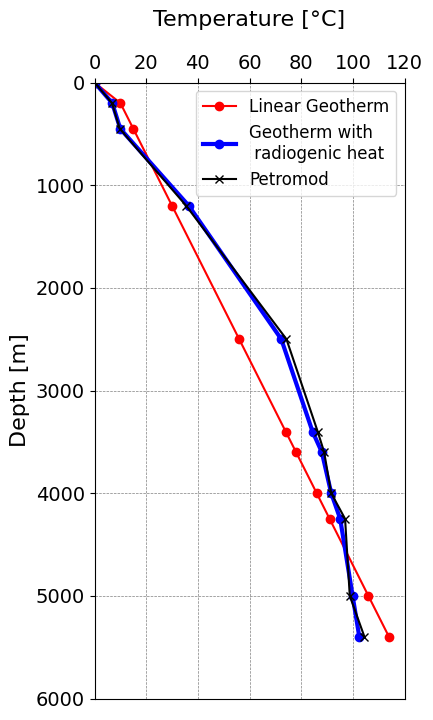

In [119]:
depth = work_layers["Depth bottom, m"].values * 1000
y = depth.tolist()

# y = work_layers["Depth bottom, m"].tolist()
y_add = y.insert(0, 0)

print(Linear, y)

C_line_petromod = [0, 6.749004094402761, 9.755323301220398, 35.46589992535598, 74.29051889984169, 86.38807927381403,
          88.87960475919344, 91.61592887733211, 96.99010868434335, 98.80038709926996, 104.49375862078024]

Linear = [0, 9.999999999999986,15.0, 29.999999999999996, 56.0, 74.0,
          78.0, 86.0, 90.99999999999997, 105.99999999999997, 113.99999999999999]

plt.figure(figsize=(4, 8))
# plt.plot(A_line, y , label='A (no A)', marker='o', color='green')
# plt.plot(T_true['0'], y , label='McKenzie')
plt.plot(Linear, y , label='Linear Geotherm', marker='o', color='red')
plt.plot(C_line, y , label='Geotherm with\n radiogenic heat', marker='o', color='blue', lw=3)
plt.plot(C_line_petromod, y, label='Petromod', marker='x', color='black')


plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

ax = plt.gca()
ax.xaxis.set_label_position('top')  # Move x-axis label to top
ax.set_xlabel('Temperature [°C]', labelpad=20, fontsize=16)
ax.set_ylabel('Depth [m]', fontsize=16)

plt.xticks(fontsize=14)  # Increase x-axis tick label size
plt.yticks(fontsize=14)  # Increase y-axis tick label size

plt.legend(fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 120)
plt.ylim(0, 6000)
plt.gca().invert_yaxis()
plt.savefig('Tempreture.png', dpi=300, bbox_inches='tight')
plt.show()

In [96]:
def makeplot(data1, data2, top_depth, bottom_depth):
    # fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    # ax = fig.subplots(1, 2,  sharex=False)

    fig, ax = plt.subplots(figsize=(14,7))

    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

### Plot 1
    # Geotherma
    T0 = 0

    x_values = data1['0'].tolist()
    x_values.insert(0, T0)
    y_values = decompaction_corrected_df['0'].tolist()
    y_values.insert(0, 0)
    ax1.plot(x_values, y_values, label='With radiation', marker='o', color='red')

    x_values = data2['0'].tolist()
    x_values.insert(0, T0)
    y_values = decompaction_corrected_df['0'].tolist()
    y_values.insert(0, 0)
    ax1.plot(x_values, y_values, label='Linear', marker='o', color='black')
    # ax1.plot(T_true['0'], decompaction_corrected_df['0'], label='McKenzie')

    ax1.set_xlabel(f'Tempreture', labelpad=20)
    ax1.set_ylabel(f'Depth (km)')
    ax1.legend()
    ax1.set_xlim([0, 120])

### Plot 2
    # Lithology track
    # ax2.plot(T_with_rad_heat["Lithology"], T_with_rad_heat['depth 0'], color = "black", linewidth = 0.5)
    ax2.set_xlabel("Lithology")
    ax2.set_xlim(0, 1)
    ax2.xaxis.label.set_color("black")
    ax2.tick_params(axis='x', colors="black")
    ax2.spines["top"].set_edgecolor("black")
    ax2.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(pd_lithology["Lithology"], decompaction_corrected_df['0']):
        key = int(lit)
        color = lithology_numbers[key]['color']
        hatch = lithology_numbers[key]['hatch']

        depth_values = [depth_start, depth]
        depth_start = depth

        ax2.fill_betweenx(depth_values, 0, 1, facecolor=color, hatch=hatch)

    ax2.set_xticks([0, 1])

### Plot3
    ax3.set_xlabel("Lithology")
    ax3.set_xlim(0, 1)
    ax3.xaxis.label.set_color("black")
    ax3.tick_params(axis='x', colors="black")
    ax3.spines["top"].set_edgecolor("black")
    ax3.set_xticks([0, 1])

    depth_start = 0

    for lit, depth in zip(pd_lithology["Lithology_type"], decompaction_corrected_df['0']):
        key = lit
        depth_values = [depth_start, depth]
        depth_start = depth

        label_position = (0.5, sum(depth_values) / 2)  # Assuming x position is at 0.5
        ax3.text(label_position[0], label_position[1], key, ha='center', va='center')
        ax3.plot([0, 1], [depth, depth], color='black', linewidth=1)  # Assuming black color and linewidth of 1



    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))

    for ax in [ax2]:
        plt.setp(ax.get_yticklabels(), visible = False)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

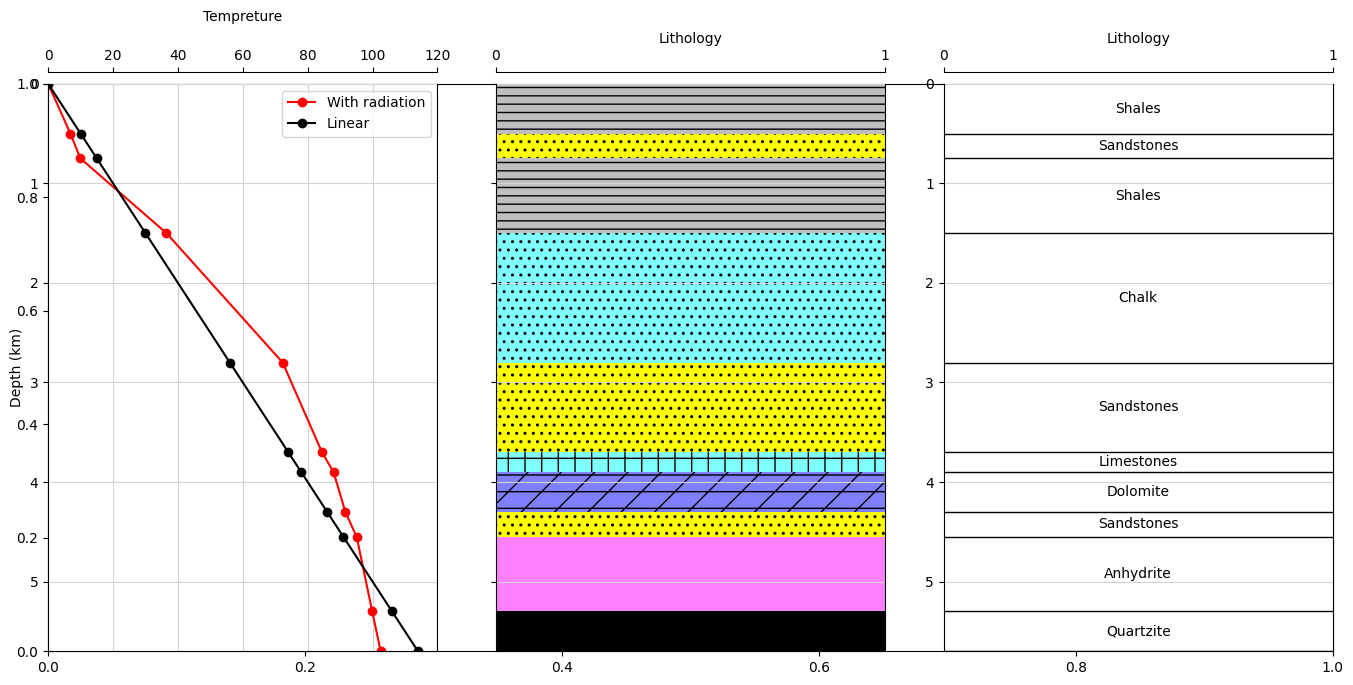

In [97]:
temperature = pd.read_csv('/content/Geotherm_with_A', skiprows=0, header=0)
linear_temperature = pd.read_csv('/content/Linear_Geotherm', skiprows=0, header=0)

makeplot(temperature, # данные 1: геотерма с изменяюшимся ТС и Радиацией
         linear_temperature,  # данные 2: линейная геотерма
         0, max(decompaction_corrected_df['0']))

### Plot: Paleotemperature

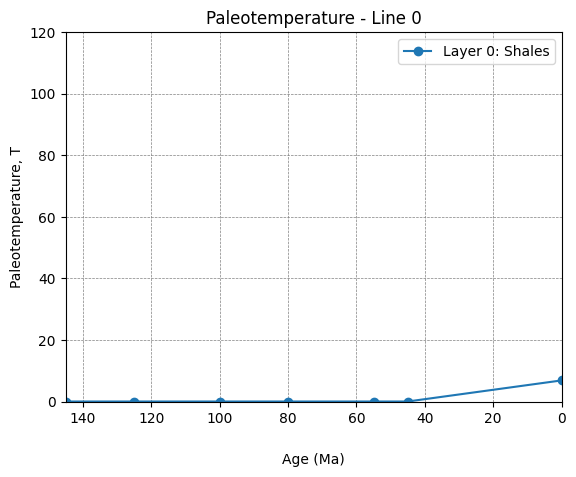

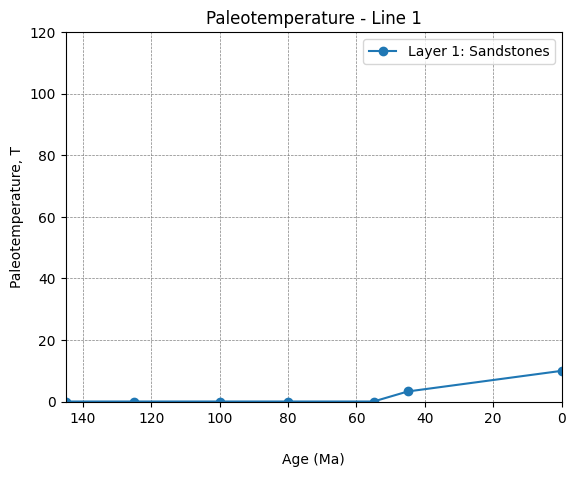

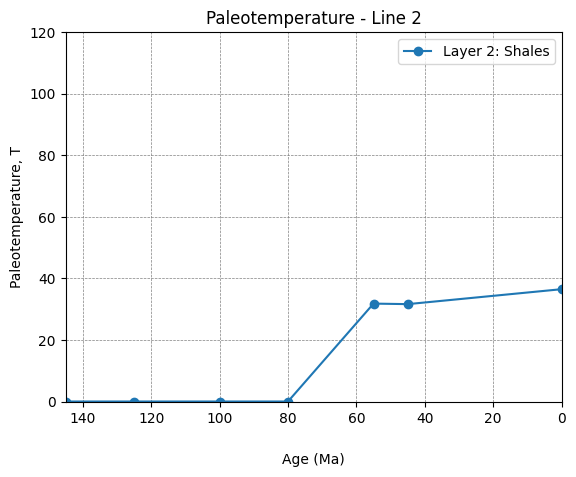

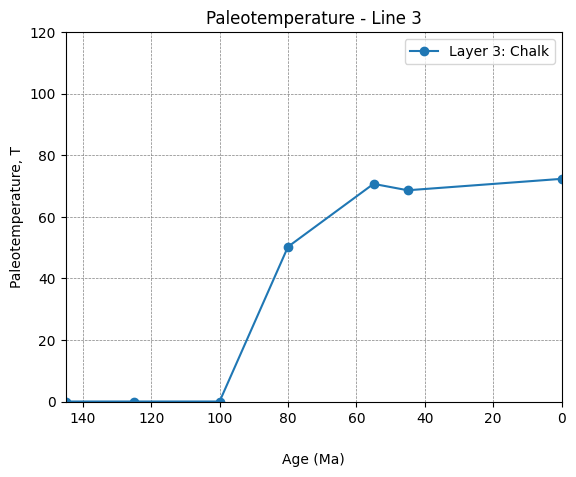

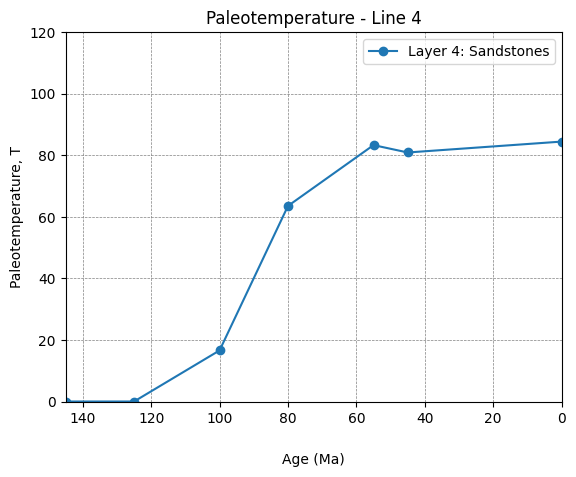

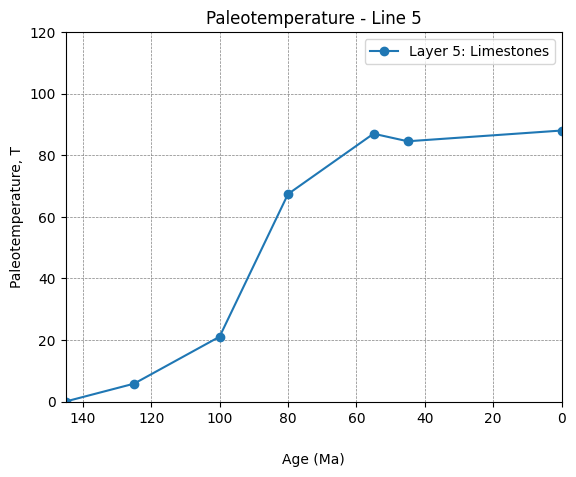

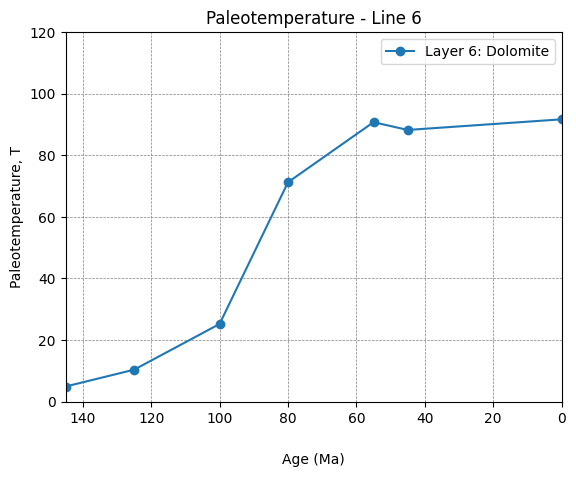

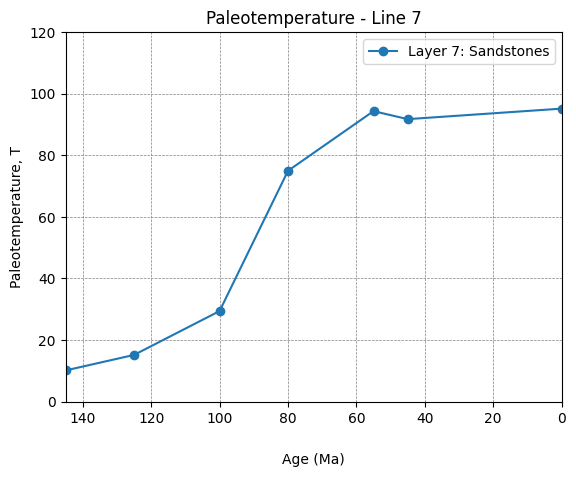

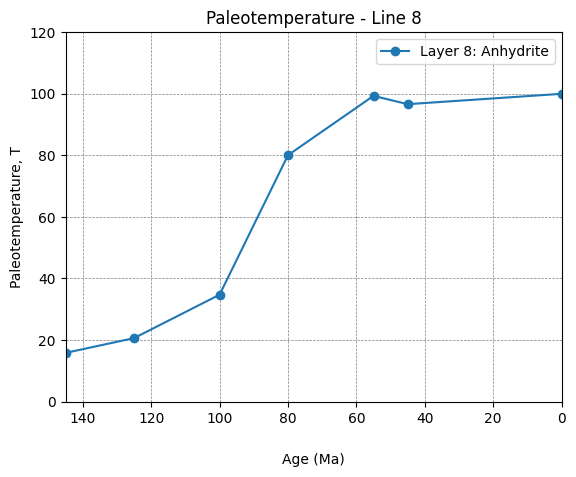

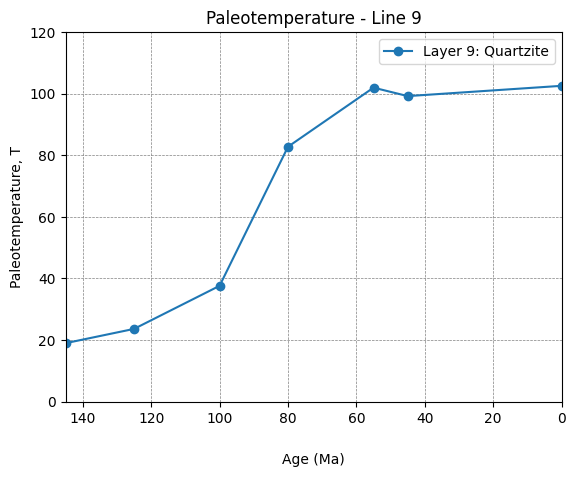

In [ ]:
age_values = [int(age) for age in df_well['Age (Ma)'][1:]]
values_for_plot = pd.read_csv('/content/Geotherm_with_A', skiprows=0, header=0)

for row_index, row in values_for_plot.iloc[0:, 3:values_for_plot.shape[1]].iterrows():
    plt.figure()  # Create a new figure for each row
    lithology = values_for_plot["Lithology_type"][row_index]
    plt.plot(age_values, row[::-1], label= "Layer "+ str(row_index) + ": "+ str(lithology), marker='o')
    plt.xlabel('Age (Ma)', labelpad=20)
    plt.ylabel('Paleotemperature, T')
    plt.legend()
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlim(0, 145)
    plt.ylim(0, 120)
    plt.gca().invert_xaxis()
    plt.title(f"Paleotemperature - Line {row_index}")
    plt.show()

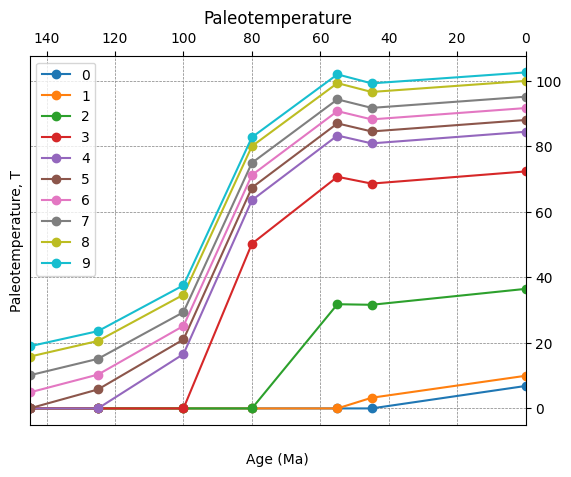

In [ ]:
age_values  = [int(age) for age in df_well['Age (Ma)'][1:]]
# print(age_values )
# print(age_values[::-1])

values_for_plot = pd.read_csv('/content/Geotherm_with_A',
                              skiprows=0, header=0)


for row_index, row in values_for_plot.iloc[0:, 3:values_for_plot.shape[1]].iterrows():
  plt.plot(age_values, row[::-1], label=str(row_index), marker='o')

# Move the x-axis label to the top
plt.xlabel('Age (Ma)', labelpad=20)
plt.ylabel('Paleotemperature, T')

# Adjust tick parameters
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 145)
plt.gca().invert_xaxis()
plt.title("Paleotemperature")


# Display the plot
plt.show()